In [89]:
# Imports
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import glob
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import seaborn as sns
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
import re
from hdbscan import HDBSCAN
#from octis.evaluation_metrics.coherence_metrics import Coherence
from umap import UMAP
import json
import pickle
from collections import Counter
import os

In [166]:
# Format text files into dataframe
def convert_text_files(directories, label):
    texts = []
    labels = []
    years = []
    filenames = []
    for directory in directories:
        text_files = glob.glob(f"{directory}/*.txt")
        for file_path in text_files:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read().strip()
                    if text:  # Only add non-empty texts
                        texts.append(text)
                        labels.append(label)
                        filenames.append(os.path.basename(file_path))
                        if directory == './GrimmFairyTale/':
                            grimm_fairy_tale_year = 1857
                            years.append(grimm_fairy_tale_year)
                        else:
                            if directory == './GrimmFairyTaleAgain/':
                                grimm_fairy_tale_again_year = 1857
                                years.append(grimm_fairy_tale_again_year)
                            else:
                                year = file_path.split('_')[-1].replace('.txt', '')
                                years.append(int(year))

            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    dataframe = pd.DataFrame({'Texts': texts, 'Labels': labels, 'Years': years, 'Filename': filenames})

    # Add Eras column
    dataframe['Era'] = dataframe['Years'].apply(lambda x:
    'Fairytale (1857)' if x <= 1857 else
    'Lovecraft (1917-1937)' if x <= 1937 else
    'Post-Lovecraft (1938-1970)' if x <= 1970 else
    'Modern (1971-2000)' if x <= 2000 else
    'Contemporary (2001+)')

    return dataframe

# Helper function to save token list and topic words to pickle file and json file
def save_token_list_and_topics(token_list, topic_words, token_file='token_list.pkl', topics_file='topic_words.json'):
    # Save token list as pickle, this helps with large lists
    with open('PickleFiles/Tokens/' + token_file, 'wb') as f:
        pickle.dump(token_list, f)

    # Save topic words as JSON to make it more readable
    with open('PickleFiles/Topics/' + topics_file, 'w') as f:
        json.dump(topic_words, f, indent=2)

# Helper function to load token list from pickle file and load topic words from json file
def load_token_list_and_topics(token_file='token_list.pkl', topics_file='topic_words.json'):
    # Load token list from pickle
    with open(token_file, 'rb') as f:
        token_list = pickle.load(f)

    # Load topic words from JSON
    with open(topics_file, 'r') as f:
        topic_words = json.load(f)

    return token_list, topic_words

In [91]:
# Helper function to calculate what proportion of words are unique across all topics (Higher is better = more diverse)
def calculate_topic_diversity(top_words_list):
    # Flatten all words
    all_words = [word for topic_words in top_words_list for word in topic_words]
    unique_words = set(all_words)

    diversity = len(unique_words) / len(all_words)

    print(f"Total words: {len(all_words)}")
    print(f"Unique words: {len(unique_words)}")

    return diversity

In [92]:
# Calculates average proportion of unique words per topic
def calculate_topic_uniqueness(top_words_list):
    # Count how many topics each word appears in
    all_words = [word for topic_words in top_words_list for word, _ in topic_words]
    word_counts = Counter(all_words)

    uniqueness_scores = []
    for topic_words in top_words_list:
        words = [word for word, _ in topic_words]
        unique_count = sum(1 for word in words if word_counts[word] == 1)
        uniqueness_scores.append(unique_count / len(words) if words else 0)

    avg_uniqueness = np.mean(uniqueness_scores)

    print(f"\nTopic Uniqueness Score: {avg_uniqueness:.4f}")

    # Show per-topic uniqueness
    for i, score in enumerate(uniqueness_scores):
        print(f"  Topic {i}: {score:.4f}")

    return avg_uniqueness, uniqueness_scores

In [93]:
# Helper function to retrieve topic list and topic words from dataframe
def get_topic_list_and_topic_words(dataframe, model):
    token_list = []
    for text in dataframe["Texts"]:
        text = text.lower()
        text = re.sub(r"[^\w\s]", "", text)
        text = text.split()
        token_list.append(text)
    topic_words = []
    for topic_id in model.get_topics():
        if topic_id != -1:
            words = [word for word, i in model.get_topic(topic_id)]
            topic_words.append(words)

    return token_list, topic_words

# Helper function to print outlier files for analysis
def print_outlier_file_names(dataframe, model):
    # Get the topic for every text in df['Texts']
    df_topics = model.get_document_info(dataframe['Texts'])

    # Retrieve outlier indicies and convert to list
    outliers_indicies = df_topics[df_topics['Topic'] == -1]['Document'].index.tolist()

    # Print outlier file names
    print("\nOutlier File Names:")
    for i, idx in enumerate(outliers_indicies, start=1):
        print(f"File {i}: {dataframe.loc[idx, 'Filename']}")

    return

In [158]:
# Sentiment mean [-1, +1] measures overall emotional tone of text, -1 is very negative and +1 is very positive, 0 is neutral
# Sentiment std measures how much sentiment varies within text or across documents (low means less fluctuation, high means a lot)
# Subjectivity mean measure how opinion-based vs factual the text is (0 means very objective, 1 means very opinionated)
# Subjectivity std measures variation in objectivity thought text (Low std means consistently objective or consistently subjective, high std means switches back and forth)
def analyze_sentiment_over_time(dataframe):
    """Track how sentiment changes over time"""

    # Calculate sentiment scores
    dataframe['Sentiment'] = dataframe['Texts'].apply(lambda x: TextBlob(x).sentiment.polarity)
    dataframe['Subjectivity'] = dataframe['Texts'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    # Compare eras
    era_sentiment = dataframe.groupby('Era').agg({
        'Sentiment': ['mean', 'std'],
        'Subjectivity': ['mean', 'std']
    }).round(4)

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    dataframe.boxplot(column='Sentiment', by='Era', ax=ax1)
    ax1.set_title('Sentiment Distribution by Era')
    ax1.set_xlabel('Era')
    ax1.set_ylabel('Sentiment Score')

    dataframe.boxplot(column='Subjectivity', by='Era', ax=ax2)
    ax2.set_title('Subjectivity Distribution by Era')
    ax2.set_xlabel('Era')
    ax2.set_ylabel('Subjectivity Score')

    plt.tight_layout()
    plt.show()

    return era_sentiment

In [94]:
# Compare topic prevalence between eras
def compare_era_topics(dataframe):
    """Compare topic distributions between different eras of lovecraft's works"""

    # Get topic counts per era
    era_topics = dataframe.groupby(['Era', 'Topic']).size().reset_index(name='Count')

    # Calculate proportions (Evenly distribute which is important for unequal corpus sizes)
    era_totals = dataframe.groupby('Era').size().to_dict()
    era_topics['Proportion'] = era_topics.apply(lambda row: row['Count'] / era_totals[row['Era']], axis=1)

    # Create comparison visualization
    pivot_prop = era_topics.pivot(index='Topic', columns='Era', values='Proportion').fillna(0)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    pivot_prop.plot(kind='bar', ax=ax, width=0.8)
    plt.title('Topic Distribution: Lovecraft vs. Modern Lovecraftian Fiction', fontsize=16)
    plt.xlabel('Topic', fontsize=12)
    plt.ylabel('Proportion of Documents', fontsize=12)
    plt.legend(title='Era', fontsize=10)
    plt.xticks(rotation=0)
    plt.tight_layout()
    # plt.savefig('lovecraft_vs_modern_topics.png', dpi=300)
    plt.show()

    return pivot_prop

In [95]:
### GLOBAL BERT TOPIC PARAMETERS ###
bert_min_topic_size = 8 # CHANGED
bert_nr_topics = 'auto' # CHANGED: was None
bert_top_n_words = 100 # CHANGED: Was 10

# Set up embedding model that has been proven to provide better accuracy for semantic meanings. Slower but higher accuracy
embedding_model = SentenceTransformer('all-mpnet-base-v2')

# Representation model
rep_model = {
    "KeyBERT": KeyBERTInspired(),
    "MMR": MaximalMarginalRelevance(diversity=0.3)
}

In [173]:
# Helper function to determine which models to configure for BERTopic
def customize_BERTopic(stop_words=True, hdbscan=True, umap=True):
    if stop_words:
        # Set up stop words
        custom_stop_words = ['said', 'went', 'came', 'saw', 'looked', 'seemed',
                             'knew', 'told', 'asked', 'thought', 'felt', 'heard',
                             'began', 'made', 'found', 'like', 'did', 'didn', 'just', 'head',
                             'feet', 'pike', 'carter', 'paris', 'don', 've', 'know', 'right', 'away',
                             'way', 'going', 'later', 'new', 'look', 'mr', 'client', 'left', 'money',
                             'soon', 'little', 'peter', 'st', 'dr', 'shall', 'wasn', 'll', 'air', 'winter', 'let',
                             'answered', 'say', 'got', 'peel']

        all_stop_words = list(ENGLISH_STOP_WORDS.union(set(custom_stop_words)))

        vectorizer = CountVectorizer(stop_words=all_stop_words,
                                     min_df=1,
                                     max_df=0.75,
                                     ngram_range=(1, 2),
                                     max_features=2000)
    else:
        vectorizer = None

    if hdbscan:
        # HDBSCAN Model
        hdbscan_model = HDBSCAN(min_cluster_size=8,
                                min_samples=3,
                                cluster_selection_epsilon=0.0,
                                cluster_selection_method='leaf',
                                prediction_data=True)
    else:
        hdbscan_model = None

    if umap:
        # UMAP Model
        umap_model = UMAP(
        n_neighbors=15,
        n_components= 5,
        min_dist=0.0,
        metric='cosine',
        random_state=42)
    else:
        umap_model = None

    return vectorizer, hdbscan_model, umap_model

In [97]:
# Helper to initialize BERTopic model with customized parameters
def init_BERTopic(custom_vectorizer, custom_hdbscan, custom_umap):
    # Initialize BERTopic model
    bertopic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=custom_vectorizer, #Stop words
        min_topic_size=bert_min_topic_size, #minimum number of documents per topic
        verbose=False,
        calculate_probabilities=True, # Calculate probability of each document belonging to which topic
        representation_model=rep_model,
        top_n_words=bert_top_n_words,
        hdbscan_model=custom_hdbscan,
        umap_model=custom_umap
    )

    return bertopic_model

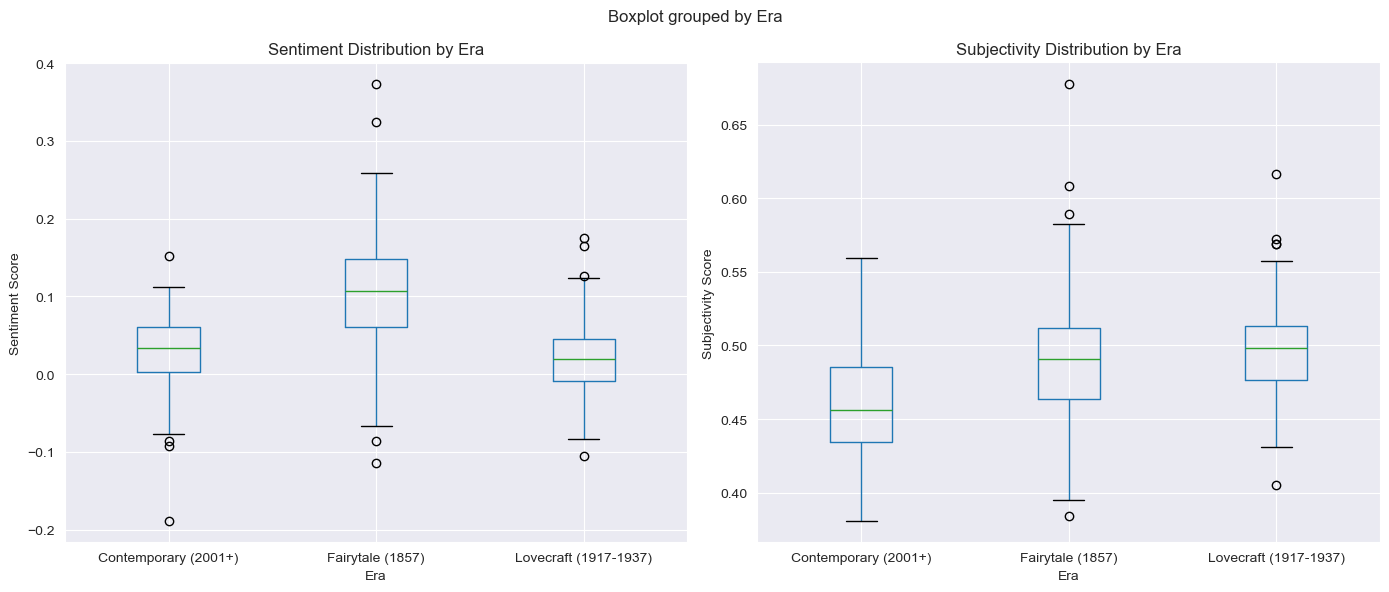

Sentiment         Subjectivity        
                           mean     std         mean     std
Era                                                         
Contemporary (2001+)     0.0284  0.0493       0.4585  0.0379
Fairytale (1857)         0.1026  0.0742       0.4899  0.0433
Lovecraft (1917-1937)    0.0201  0.0482       0.4972  0.0338

In [172]:
# Sentiment analysis for all genres
df = convert_text_files(directories=['./fiction_text_files/', './Fan_text_files', './GrimmFairyTaleAgain/'], label='fiction')
analyze_sentiment_over_time(df)

In [98]:
### Using custom stop words, hdbscan, umap ###

df = convert_text_files(directories=['./fiction_text_files/'], label='fiction')

# Initialize BERTopic model using custom parameters (Use custom stop words, hdbscan, umap)
topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fiction_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fiction_text_top_words.append(current_topic_top_words)

print()

# Get average probabilities for each topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fiction_text_diversity_score = calculate_topic_diversity(fiction_text_top_words)
print(f"Fiction Text Diversity Score: {fiction_text_diversity_score}")

# Compute Uniqueness Score
fiction_uniqueness, fiction_per_topic_uniqueness = calculate_topic_uniqueness(fiction_text_top_words)

print()

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fiction_tokens_all_configs.pkl',
                           'fiction_topics_all_configs.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4381547240132947


=== Topic Information ===
   Topic  Count                                  Name  \
0     -1     25    -1_rogers_whateley_armitage_wilbur   
1      0     36            0_akeley_ammi_nahum_gaunts   
2      1     20   1_curwen_willett_clarendon_georgina   
3      2     15  2_zamacona_danforth_jermyn_antarctic   
4      3      8          3_innsmouth_moore_mummy_obed   

                                      Representation  \
0  [rogers, whateley, armitage, wilbur, randolph,...   
1  [akeley, ammi, nahum, gaunts, night gaunts, de...   
2  [curwen, willett, clarendon, georgina, gilman,...   
3  [zamacona, danforth, jermyn, antarctic, yan, g...   
4  [innsmouth, moore, mummy, obed, ghatanothoa, a...   

                                             KeyBERT  \
0  [exham priory, priory, old whateley, wilbur wh...   
1  [waking world, nameless city, akeley, dreamlan...   
2  [antiquarian, hamlet, reanimation, black fever...   
3  [archaean, primordial, tribes, pyramids, amnes...   
4  [submarine

In [99]:
### Using custom stop words, hdbscan ###
df = convert_text_files(directories=['./fiction_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fiction_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fiction_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fiction_text_diversity_score = calculate_topic_diversity(fiction_text_top_words)
print(f"Fiction Text Diversity Score: {fiction_text_diversity_score}")

# Compute Uniqueness Score
fiction_uniqueness, fiction_per_topic_uniqueness = calculate_topic_uniqueness(fiction_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fiction_tokens_stop_words_hdbscan.pkl',
                           'fiction_topics_stop_words_hdbscan.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.36936814068623147


=== Topic Information ===
   Topic  Count                               Name  \
0     -1     38        -1_akeley_ghouls_jones_ones   
1      0     31      0_ward_curwen_willett_charles   
2      1     13  1_zamacona_old ones_ones_danforth   
3      2     13      2_musides_beach_kalos_kuranes   
4      3      9       3_iranon_sarnath_yalden_aira   

                                      Representation  \
0  [akeley, ghouls, jones, ones, cats, randolph, ...   
1  [ward, curwen, willett, charles, clarendon, gi...   
2  [zamacona, old ones, ones, danforth, jermyn, a...   
3  [musides, beach, kalos, kuranes, zann, cohort,...   
4  [iranon, sarnath, yalden, aira, barzai, namele...   

                                             KeyBERT  \
0  [priory, wilbur, whateley, akeley, ghouls, dre...   
1  [specimens, fever, experiments, rat, diary, co...   
2  [archaean, myths, snakes, antarctic, specimens...   
3  [poets, sepulchre, mural, kuranes, churchyard,...   
4  [earth gods, altars, nameles

In [100]:
### Using custom stop words, umap ###

df = convert_text_files(directories=['./fiction_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fiction_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fiction_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fiction_text_diversity_score = calculate_topic_diversity(fiction_text_top_words)
print(f"Fiction Text Diversity Score: {fiction_text_diversity_score}")

# Compute Uniqueness Score
fiction_uniqueness, fiction_per_topic_uniqueness = calculate_topic_uniqueness(fiction_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fiction_tokens_stop_words_umap.pkl',
                           'fiction_topics_stop_words_umap.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.3566118144852333


=== Topic Information ===
   Topic  Count                                     Name  \
0     -1     40         -1_akeley_marsh_innsmouth_robert   
1      0     26             0_ward_curwen_willett_doctor   
2      1     24  1_gaunts_night gaunts_galley_great ones   
3      2     14        2_zamacona_danforth_antarctic_yan   

                                      Representation  \
0  [akeley, marsh, innsmouth, robert, ammi, nahum...   
1  [ward, curwen, willett, doctor, clarendon, jon...   
2  [gaunts, night gaunts, galley, great ones, ngr...   
3  [zamacona, danforth, antarctic, yan, yig, grea...   

                                             KeyBERT  \
0  [akeley, priory, innsmouth, farmhouse, old bug...   
1  [specimens, mummy, wilbur, mrs ward, rat, char...   
2  [earth gods, palaces, waking world, monastery,...   
3  [archaean, exploring, pyramids, antarctic, amn...   

                                                 MMR  \
0  [akeley, folks, priory, bog, specimens, herber...  

In [101]:
### Using custom stop words only ###

df = convert_text_files(directories=['./fiction_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fiction_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fiction_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fiction_text_diversity_score = calculate_topic_diversity(fiction_text_top_words)
print(f"Fiction Text Diversity Score: {fiction_text_diversity_score}")

# Compute Uniqueness Score
fiction_uniqueness, fiction_per_topic_uniqueness = calculate_topic_uniqueness(fiction_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)

# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fiction_tokens_stop_words.pkl',
                           'fiction_topics_stop_words.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.3888868340658594


=== Topic Information ===
   Topic  Count                                     Name  \
0     -1     36            -1_ward_curwen_willett_akeley   
1      0     29  0_night gaunts_gaunts_galley_great ones   
2      1     27        1_clarendon_jones_gilman_georgina   
3      2     12        2_zamacona_danforth_jermyn_scroll   

                                      Representation  \
0  [ward, curwen, willett, akeley, ye, marsh, inn...   
1  [night gaunts, gaunts, galley, great ones, ngr...   
2  [clarendon, jones, gilman, georgina, rogers, w...   
3  [zamacona, danforth, jermyn, scroll, yan, maso...   

                                             KeyBERT  \
0  [salem, swamp, providence, specimens, akeley, ...   
1  [earth gods, palaces, waking world, monastery,...   
2  [wilbur whateley, old whateley, priory, wilbur...   
3  [exploration, archaean, specimens, mummy, pyra...   

                                                 MMR  \
0  [willett, innsmouth, joseph curwen, folks, far...  

In [102]:
### Using custom stop words, hdbscan, umap ###
df = convert_text_files(directories=['./Fan_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fan_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fan_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fan_text_diversity_score = calculate_topic_diversity(fan_text_top_words)
print(f"Fan Text Diversity Score: {fan_text_diversity_score}")

# Compute Uniqueness Score
fan_uniqueness, fan_per_topic_uniqueness = calculate_topic_uniqueness(fan_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fan_tokens_all_configs.pkl', 'fan_topics_all_configs.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4872462460638685


=== Topic Information ===
   Topic  Count                              Name  \
0     -1     50  -1_emerson_hastur_hamilton_nadia   
1      0     23         0_mazlo_darby_oskar_billy   
2      1     23         1_hex_calum_cyprian_alejo   
3      2      8              2_sam_karen_mike_ray   

                                      Representation  \
0  [emerson, hastur, hamilton, nadia, hera, jobe,...   
1  [mazlo, darby, oskar, billy, lenora, anne, vic...   
2  [hex, calum, cyprian, alejo, wolf, noolan, ric...   
3  [sam, karen, mike, ray, moore, eddie, tcho, ca...   

                                             KeyBERT  \
0  [sergeant, soldiers, officer, military, missio...   
1  [morgue, outline, parents, mom, mum, watchers,...   
2  [cave, stalks, servants, harvest, island, cast...   
3  [patients, mused, drugs, mob, mike, drug, work...   

                                                 MMR  \
0  [wilmarth, welles, soldiers, jacqueline, conne...   
1  [sara, ken, morgue, dolores, g

In [103]:
### Using custom stop words, hdbscan ###
df = convert_text_files(directories=['./Fan_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fan_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fan_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fan_text_diversity_score = calculate_topic_diversity(fan_text_top_words)
print(f"Fan Text Diversity Score: {fan_text_diversity_score}")

# Compute Uniqueness Score
fan_uniqueness, fan_per_topic_uniqueness = calculate_topic_uniqueness(fan_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fan_tokens_stop_words_hdbscan.pkl', 'fan_topics_stop_words_hdbscan.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4337482915284432


=== Topic Information ===
   Topic  Count                              Name  \
0     -1     46  -1_cyprian_hastur_hamilton_calum   
1      0     20          0_hera_dummy_mazlo_darby   
2      1     10  1_oskar_victoria_fuchs_anastasia   
3      2     10        2_emerson_jobe_louis_myles   
4      3     10            3_ricou_iggy_leon_koro   
5      4      8              4_sam_karen_mike_ray   

                                      Representation  \
0  [cyprian, hastur, hamilton, calum, hex, kane, ...   
1  [hera, dummy, mazlo, darby, ava, billy, lenora...   
2  [oskar, victoria, fuchs, anastasia, aliza, con...   
3  [emerson, jobe, louis, myles, brooks, amye, da...   
4  [ricou, iggy, leon, koro, banefire, jack, riss...   
5  [sam, karen, mike, ray, moore, eddie, tcho, ca...   

                                             KeyBERT  \
0  [welles, victim, jacques, film, grimoire, isla...   
1  [ventriloquism, greater ventriloquism, ventril...   
2  [paintings, scars, emotions, conclusi

In [104]:
### Using custom stop words, umap ###
df = convert_text_files(directories=['./Fan_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fan_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fan_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fan_text_diversity_score = calculate_topic_diversity(fan_text_top_words)
print(f"Fan Text Diversity Score: {fan_text_diversity_score}")

# Compute Uniqueness Score
fan_uniqueness, fan_per_topic_uniqueness = calculate_topic_uniqueness(fan_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fan_tokens_stop_words_umap.pkl', 'fan_topics_stop_words_umap.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.5615579269069118


=== Topic Information ===
   Topic  Count                                Name  \
0     -1     55  -1_emerson_cyprian_hastur_hamilton   
1      0     25           0_dummy_mazlo_darby_billy   
2      1     24             1_calum_jobe_louis_wolf   

                                      Representation  \
0  [emerson, cyprian, hastur, hamilton, nadia, he...   
1  [dummy, mazlo, darby, billy, lenora, anne, sar...   
2  [calum, jobe, louis, wolf, ricou, dennis, kurt...   

                                             KeyBERT  \
0  [sergeant, police, armitage, crime, inspector,...   
1  [ventriloquism, greater ventriloquism, ventril...   
2  [harvest, wolf corn, cave, servants, musket, v...   

                                                 MMR  \
0  [wilmarth, welles, jacqueline, drood, connelly...   
1  [darby, billy, vox, rachel, dummies, greater v...   
2  [bogolyubov, hugo, legion, combines, dark god,...   

                                 Representative_Docs  
0  [Sergeant Emerson J

In [105]:
### Using custom stop words only ###
df = convert_text_files(directories=['./Fan_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fan_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fan_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fan_text_diversity_score = calculate_topic_diversity(fan_text_top_words)
print(f"Fan Text Diversity Score: {fan_text_diversity_score}")

# Compute Uniqueness Score
fan_uniqueness, fan_per_topic_uniqueness = calculate_topic_uniqueness(fan_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fan_tokens_stop_words.pkl', 'fan_topics_stop_words.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.5958840922751167


=== Topic Information ===
   Topic  Count                                Name  \
0     -1     38  -1_emerson_cyprian_hastur_hamilton   
1      0     39            0_hera_dummy_mazlo_karen   
2      1     27           1_jobe_louis_garner_ricou   

                                      Representation  \
0  [emerson, cyprian, hastur, hamilton, nadia, he...   
1  [hera, dummy, mazlo, karen, darby, oskar, bill...   
2  [jobe, louis, garner, ricou, dennis, bishop, c...   

                                             KeyBERT  \
0  [armitage, sergeant, jacques, crime, museum, w...   
1  [ventriloquism, greater ventriloquism, ventril...   
2  [crevasse, operation, camp, diver, sledge, leg...   

                                                 MMR  \
0  [wilmarth, welles, professor, grimoire, evelyn...   
1  [darby, billy, gingerbread man, vox, anastasia...   
2  [kurtzberg, connelly, riss, insurgents, herr h...   

                                 Representative_Docs  
0  [Sergeant Emerson J

In [106]:
### Using custom stop words, hdbscan, umap ###

df = convert_text_files(directories=['./GrimmFairyTale/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_fairy_tale_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_fairy_tale_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_text_diversity_score = calculate_topic_diversity(grimm_fairy_tale_text_top_words)
print(f"Grimm Fairytale Text Diversity Score: {grimm_text_diversity_score}")

# Compute Uniqueness Score
grimm_uniqueness, grimm_per_topic_uniqueness = calculate_topic_uniqueness(grimm_fairy_tale_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_tokens_all_configs.pkl', 'grimm_topics_all_configs.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4715667218242559


=== Topic Information ===
   Topic  Count                                      Name  \
0     -1     50         -1_gretel_old woman_mountain_sick   
1      0     44                   0_fox_hedgehog_wolf_cat   
2      1     33  1_lustig_brother lustig_shudder_knapsack   
3      2     18                2_fox_soldier_spear_schulz   
4      3     18       3_snow white_glass_cinderella_elsie   
5      4     17          4_tailor_giant_thumbling_bailiff   
6      5     17     5_john_faithful john_old woman_maleen   
7      6      8         6_griffin_simpleton_frog_youngest   

                                      Representation  \
0  [gretel, old woman, mountain, sick, dragon, fl...   
1  [fox, hedgehog, wolf, cat, devil, frederick, c...   
2  [lustig, brother lustig, shudder, knapsack, je...   
3  [fox, soldier, spear, schulz, cap, giants, mas...   
4  [snow white, glass, cinderella, elsie, red cap...   
5  [tailor, giant, thumbling, bailiff, thief, sho...   
6  [john, faithful john, old wo

In [107]:
### Using custom stop words, hdbscan ###

df = convert_text_files(directories=['./GrimmFairyTale/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_fairy_tale_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_fairy_tale_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_text_diversity_score = calculate_topic_diversity(grimm_fairy_tale_text_top_words)
print(f"Grimm Fairytale Text Diversity Score: {grimm_text_diversity_score}")

# Compute Uniqueness Score
grimm_uniqueness, grimm_per_topic_uniqueness = calculate_topic_uniqueness(grimm_fairy_tale_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_tokens_stop_words_hdbscan.pkl', 'grimm_topics_stop_words_hdbscan.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.48205797048375093


=== Topic Information ===
   Topic  Count                                            Name  \
0     -1     48             -1_gretel_tailor_thumbling_flounder   
1      0     56               0_boy_lustig_brother lustig_bride   
2      1     40                1_old woman_snow white_hare_sick   
3      2     17                      2_huntsman_lion_dragon_fox   
4      3     16                         3_fox_wolf_sparrow_goat   
5      4     11                  4_tailor_shoemaker_thief_count   
6      5      9               5_griffin_simpleton_frog_king son   
7      6      8  6_godfather_ferdinand_devil_ferdinand faithful   

                                      Representation  \
0  [gretel, tailor, thumbling, flounder, hansel, ...   
1  [boy, lustig, brother lustig, bride, king son,...   
2  [old woman, snow white, hare, sick, glass, dru...   
3  [huntsman, lion, dragon, fox, animals, hare, s...   
4  [fox, wolf, sparrow, goat, cat, aik, meh, cows...   
5  [tailor, shoemaker, thief, cou

In [108]:
### Using custom stop words, umap ###

df = convert_text_files(directories=['./GrimmFairyTale/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_fairy_tale_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_fairy_tale_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_text_diversity_score = calculate_topic_diversity(grimm_fairy_tale_text_top_words)
print(f"Grimm Fairytale Text Diversity Score: {grimm_text_diversity_score}")

# Compute Uniqueness Score
grimm_uniqueness, grimm_per_topic_uniqueness = calculate_topic_uniqueness(grimm_fairy_tale_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_tokens_stop_words_umap.pkl', 'grimm_topics_stop_words_umap.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.5335260610943757


=== Topic Information ===
   Topic  Count                                      Name  \
0     -1     67         -1_gretel_tailor_thumbling_dragon   
1      0     41  0_brother lustig_lustig_knapsack_shudder   
2      1     38         1_sick_drummer_john_faithful john   
3      2     31       2_hedgehog_wolf_frederick_catherine   
4      3     15       3_tailor_griffin_dummling_simpleton   
5      4     13     4_spear_schulz_master schulz_wild man   

                                      Representation  \
0  [gretel, tailor, thumbling, dragon, flounder, ...   
1  [brother lustig, lustig, knapsack, shudder, je...   
2  [sick, drummer, john, faithful john, cinderell...   
3  [hedgehog, wolf, frederick, catherine, sparrow...   
4  [tailor, griffin, dummling, simpleton, shoemak...   
5  [spear, schulz, master schulz, wild man, golde...   

                                             KeyBERT  \
0  [hansel, hans gretel, thee, mother holle, gret...   
1  [forbidden door, beggar, brother lust

In [109]:
### Using custom stop words only ###

df = convert_text_files(directories=['./GrimmFairyTale/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_fairy_tale_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_fairy_tale_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_text_diversity_score = calculate_topic_diversity(grimm_fairy_tale_text_top_words)
print(f"Grimm Fairytale Text Diversity Score: {grimm_text_diversity_score}")

# Compute Uniqueness Score
grimm_uniqueness, grimm_per_topic_uniqueness = calculate_topic_uniqueness(grimm_fairy_tale_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_tokens_stop_words.pkl', 'grimm_topics_stop_words.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4043307736740826


=== Topic Information ===
   Topic  Count                                 Name  \
0     -1     76    -1_hans_old woman_gretel_mountain   
1      0     36   0_lord_lustig_brother lustig_devil   
2      1     21          1_tailor_hans_giant_griffin   
3      2     16    2_john_faithful john_queen_prince   
4      3     16            3_fox_castle_schulz_spear   
5      4     14  4_hedgehog_cock_frederick_catherine   
6      5     13              5_fox_wolf_sparrow_goat   
7      6     13  6_snow white_cinderella_red cap_cap   

                                      Representation  \
0  [hans, old woman, gretel, mountain, soldier, d...   
1  [lord, lustig, brother lustig, devil, knapsack...   
2  [tailor, hans, giant, griffin, castle, dummlin...   
3  [john, faithful john, queen, prince, old woman...   
4  [fox, castle, schulz, spear, giants, golden ho...   
5  [hedgehog, cock, frederick, catherine, hans he...   
6  [fox, wolf, sparrow, goat, miller, meh, cudgel...   
7  [snow white, cind

In [110]:
### Using custom stop words, hdbscan, umap ###

df = convert_text_files(directories=['./GrimmFairyTaleAgain/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_text_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_text_top_words)
print(f"Grimm Fairytale Again Text Diversity Score: {grimm_again_text_diversity_score}")

# Compute Uniqueness Score
grimm_again_uniqueness, grimm_again_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_tokens_all_configs.pkl', 'grimm_again_topics_all_configs.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4950329240974002


=== Topic Information ===
   Topic  Count                                      Name  \
0     -1     33              -1_gretel_goat_tailor_hansel   
1      0     34  0_tailor_lustig_brother lustig_thumbling   
2      1     18  1_john_faithful john_marlinchen_rapunzel   
3      2     10                    2_fox_lion_dragon_hare   
4      3      8    3_cinderella_elsie_red cap_grandmother   

                                      Representation  \
0  [gretel, goat, tailor, hansel, snow white, pea...   
1  [tailor, lustig, brother lustig, thumbling, he...   
2  [john, faithful john, marlinchen, rapunzel, ju...   
3  [fox, lion, dragon, hare, host, marshal, golde...   
4  [cinderella, elsie, red cap, grandmother, roeb...   

                                             KeyBERT  \
0  [hansel gretel, seven dwarfs, dwarfs, hansel, ...   
1  [peasant, tailor, dwarf, riddle, pig, brother ...   
2  [father ate, coffins, aged king, golden dwelli...   
3  [soaring lark, golden bird, gold pieces, o

In [111]:
### Using custom stop words, hdbscan ###

df = convert_text_files(directories=['./GrimmFairyTaleAgain/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_text_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_text_top_words)
print(f"Grimm Fairytale Again Text Diversity Score: {grimm_again_text_diversity_score}")

# Compute Uniqueness Score
grimm_again_uniqueness, grimm_again_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_tokens_stop_words_hdbscan.pkl', 'grimm_again_topics_stop_words_hdbscan.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4564727864186764


=== Topic Information ===
   Topic  Count                                      Name  \
0     -1     37                -1_tailor_gretel_hans_goat   
1      0     27    0_brother lustig_lustig_soldier_dragon   
2      1     17  1_faithful john_john_marlinchen_rapunzel   
3      2     14   2_hans_thumbling_hedgehog_hans hedgehog   
4      3      8  3_cinderella_red cap_grandmother_roebuck   

                                      Representation  \
0  [tailor, gretel, hans, goat, snow white, hanse...   
1  [brother lustig, lustig, soldier, dragon, fox,...   
2  [faithful john, john, marlinchen, rapunzel, ju...   
3  [hans, thumbling, hedgehog, hans hedgehog, bai...   
4  [cinderella, red cap, grandmother, roebuck, ra...   

                                             KeyBERT  \
0  [hansel gretel, clever elsie, hansel, peasant,...   
1  [golden bird, earned, golden horse, brother lu...   
2  [father ate, coffins, grave, aged king, golden...   
3  [peasant, pig, thumbling, hans hedgehog, h

In [112]:
### Using custom stop words, umap ###

df = convert_text_files(directories=['./GrimmFairyTaleAgain/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_text_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_text_top_words)
print(f"Grimm Fairytale Again Text Diversity Score: {grimm_again_text_diversity_score}")

# Compute Uniqueness Score
grimm_again_uniqueness, grimm_again_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_tokens_stop_words_umap.pkl', 'grimm_again_topics_stop_words_umap.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.48512264885112916


=== Topic Information ===
   Topic  Count                               Name  \
0     -1     51      -1_tailor_gretel_goat_peasant   
1      0     29  0_sister_faithful john_john_bride   
2      1     14     1_shudder_devil_bearskin_dwarf   
3      2      9             2_fox_dragon_lion_hare   

                                      Representation  \
0  [tailor, gretel, goat, peasant, brother lustig...   
1  [sister, faithful john, john, bride, cook, cin...   
2  [shudder, devil, bearskin, dwarf, seven years,...   
3  [fox, dragon, lion, hare, host, marshal, golde...   

                                             KeyBERT  \
0  [peasant, tailor, dwarfs, hungry, letter, shoe...   
1  [cinderella, true bride, sisters, sister, witc...   
2  [devil, hell, dwarf, riddle, clever, earn brea...   
3  [huntsmen, feathers, golden bird, bird heart, ...   

                                                 MMR  \
0  [tailor, peasant, snow white, hansel, letter, ...   
1  [faithful john, rapunzel,

In [113]:
### Using custom stop words only ###

df = convert_text_files(directories=['./GrimmFairyTaleAgain/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_text_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_text_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_text_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_text_top_words)
print(f"Grimm Fairytale Again Text Diversity Score: {grimm_again_text_diversity_score}")

# Compute Uniqueness Score
grimm_again_uniqueness, grimm_again_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_text_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_tokens_stop_words.pkl', 'grimm_again_topics_stop_words.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.5625046137440477


=== Topic Information ===
   Topic  Count                                  Name  \
0     -1     42         -1_tailor_gretel_goat_peasant   
1      0     32  0_faithful john_john_cinderella_pick   
2      1     29    1_lustig_brother lustig_fox_dragon   

                                      Representation  \
0  [tailor, gretel, goat, peasant, hansel, thumbl...   
1  [faithful john, john, cinderella, pick, elsie,...   
2  [lustig, brother lustig, fox, dragon, hedgehog...   

                                             KeyBERT  \
0  [hansel gretel, peasant, tailor, hansel, riddl...   
1  [cinderella, seven dwarfs, true bride, virgin ...   
2  [brother lustig, treasure, eggs, king eats, th...   

                                                 MMR  \
0  [tailor, peasant, stag, golden apples, hansel ...   
1  [faithful john, cinderella, enchantress, cleve...   
2  [brother lustig, knapsack, hans hedgehog, king...   

                                 Representative_Docs  
0  [There was 

In [154]:
### Using custom stop words, hdbscan, umap ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/','./GrimmFairyTale/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
all_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        all_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
all_corpus_diversity_score = calculate_topic_diversity(all_corpus_top_words)
print(f"All Corpus Text Diversity Score: {all_corpus_diversity_score}")

# Compute Uniqueness Score
all_corpus_uniqueness, all_corpus_per_topic_uniqueness = calculate_topic_uniqueness(all_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'all_corpus_tokens_all_configs.pkl', 'all_corpus_topics_all_configs.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4399290546130862


=== Topic Information ===
   Topic  Count                                  Name  \
0     -1    124          -1_emerson_cyprian_nadia_hex   
1      0    150  0_tailor_king daughter_huntsman_hare   
2      1     95          1_ward_curwen_willett_hastur   
3      2     25   2_ghouls_gaunts_night gaunts_kadath   
4      3     19      3_jobe_garner_danforth_kurtzberg   

                                      Representation  \
0  [emerson, cyprian, nadia, hex, dummy, kane, gi...   
1  [tailor, king daughter, huntsman, hare, king s...   
2  [ward, curwen, willett, hastur, charles, akele...   
3  [ghouls, gaunts, night gaunts, kadath, onyx, g...   
4  [jobe, garner, danforth, kurtzberg, antarctic,...   

                                             KeyBERT  \
0  [ventriloquism, mission, leary, armitage, well...   
1  [innkeeper, merry, dwarfs, huntsmen, fisherman...   
2  [specimens, diary, cthulhu, wilbur, gaston, ch...   
3  [altars, shrines, waking world, pnakotic manus...   
4  [antarctic

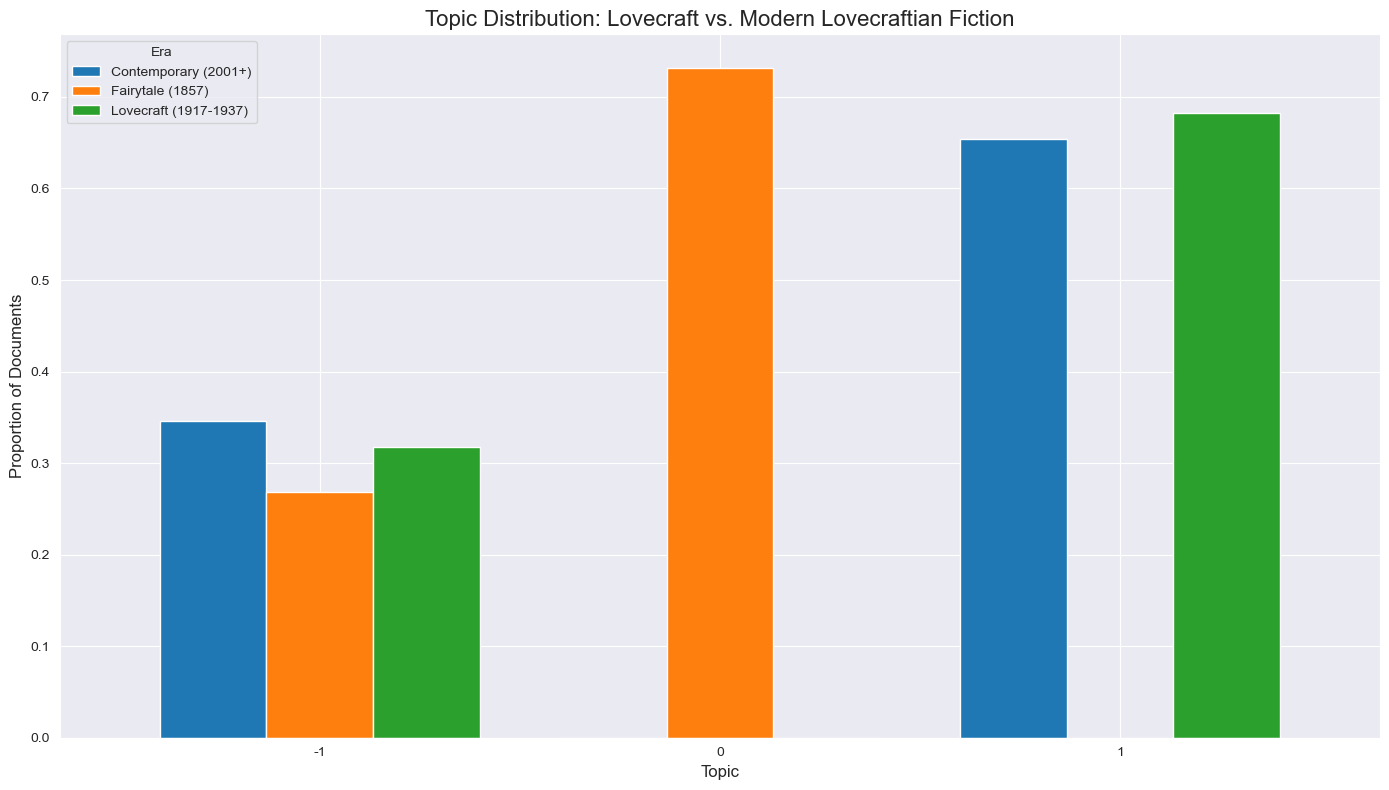


=== Topic Proportions ===
Era    Contemporary (2001+)  Fairytale (1857)  Lovecraft (1917-1937)
Topic                                                               
-1                 0.346154          0.268293               0.317308
 0                 0.000000          0.731707               0.000000
 1                 0.653846          0.000000               0.682692


In [115]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [116]:
### Using custom stop words, hdbscan ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/','./GrimmFairyTale/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
all_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        all_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
all_corpus_diversity_score = calculate_topic_diversity(all_corpus_top_words)
print(f"All Corpus Text Diversity Score: {all_corpus_diversity_score}")

# Compute Uniqueness Score
all_corpus_uniqueness, all_corpus_per_topic_uniqueness = calculate_topic_uniqueness(all_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'all_corpus_tokens_stop_words_hdbscan.pkl', 'all_corpus_topics_stop_words_hdbscan.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.3915508087902008


=== Topic Information ===
   Topic  Count                                            Name  \
0     -1    142                   -1_hastur_zamacona_calum_kane   
1      0    138                      0_ward_gods_emerson_curwen   
2      1    133  1_king daughter_huntsman_tailor_brother lustig   

                                      Representation  \
0  [hastur, zamacona, calum, kane, nadia, cyprian...   
1  [ward, gods, emerson, curwen, ye, charles, ahe...   
2  [king daughter, huntsman, tailor, brother lust...   

                                             KeyBERT  \
0  [museum, mummy, welles, gaston, shadows, phant...   
1  [specimens, grotesque, horrors, papers, corpse...   
2  [huntsmen, huntsman, sparrow, hansel, rich man...   

                                                 MMR  \
0  [hastur, wilmarth, welles, museum, manuscript,...   
1  [ward, emerson, nameless, arkham, library, gho...   
2  [tailor, brother lustig, huntsmen, catherine, ...   

                             

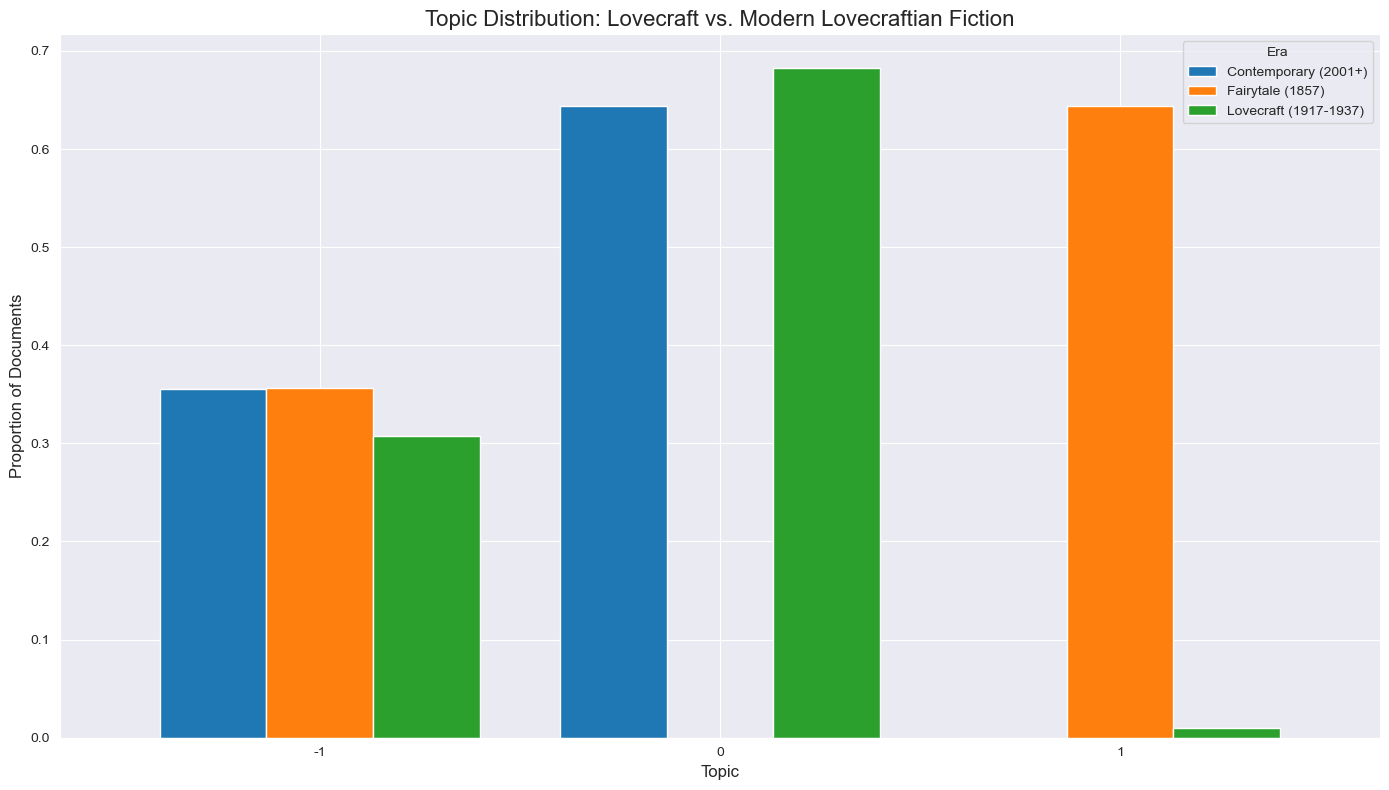


=== Topic Proportions ===
Era    Contemporary (2001+)  Fairytale (1857)  Lovecraft (1917-1937)
Topic                                                               
-1                 0.355769          0.356098               0.307692
 0                 0.644231          0.000000               0.682692
 1                 0.000000          0.643902               0.009615


In [117]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [118]:
### Using custom stop words, umap ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/','./GrimmFairyTale/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
all_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        all_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
all_corpus_diversity_score = calculate_topic_diversity(all_corpus_top_words)
print(f"All Corpus Text Diversity Score: {all_corpus_diversity_score}")

# Compute Uniqueness Score
all_corpus_uniqueness, all_corpus_per_topic_uniqueness = calculate_topic_uniqueness(all_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'all_corpus_tokens_stop_words_umap.pkl', 'all_corpus_topics_stop_words_umap.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.40392540549281897


=== Topic Information ===
   Topic  Count                                    Name  \
0      0    207  0_tailor_king daughter_huntsman_gretel   
1      1    206              1_ward_gods_ahead_probably   

                                      Representation  \
0  [tailor, king daughter, huntsman, gretel, hedg...   
1  [ward, gods, ahead, probably, metal, wholly, c...   

                                             KeyBERT  \
0  [huntsmen, huntsman, dwarfs, hansel, cinderell...   
1  [horrors, museum, ghouls, grotesque, alien, co...   

                                                 MMR  \
0  [tailor, gretel, hansel, cinderella, hans hedg...   
1  [ward, ahead, arkham, library, various, centur...   

                                 Representative_Docs  
0  [There was once a man who understood all kinds...  
1  [“The essential Saltes of Animals may be so pr...  

Topic 0:
[('tailor', 0.6260641281628178), ('king daughter', 0.5194441631054035), ('huntsman', 0.481818579961294), ('gretel

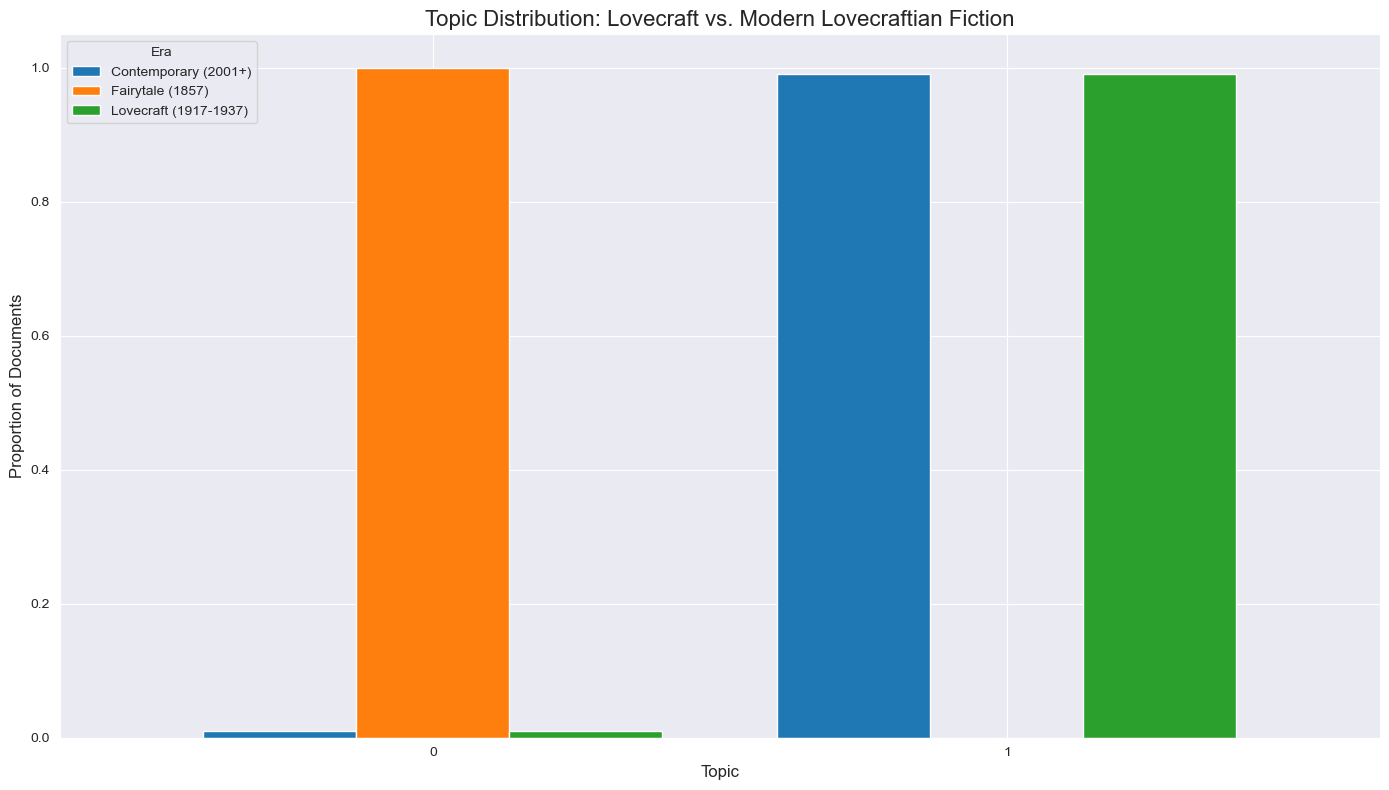


=== Topic Proportions ===
Era    Contemporary (2001+)  Fairytale (1857)  Lovecraft (1917-1937)
Topic                                                               
0                  0.009615               1.0               0.009615
1                  0.990385               0.0               0.990385


In [119]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [120]:
### Using custom stop words only ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/','./GrimmFairyTale/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
all_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        all_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
all_corpus_diversity_score = calculate_topic_diversity(all_corpus_top_words)
print(f"All Corpus Text Diversity Score: {all_corpus_diversity_score}")

# Compute Uniqueness Score
all_corpus_uniqueness, all_corpus_per_topic_uniqueness = calculate_topic_uniqueness(all_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'all_corpus_tokens_stop_words.pkl', 'all_corpus_topics_stop_words.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.42875325109059637


=== Topic Information ===
   Topic  Count                                    Name  \
0      0    209  0_tailor_king daughter_huntsman_gretel   
1      1    204            1_ward_probably_metal_wholly   

                                      Representation  \
0  [tailor, king daughter, huntsman, gretel, hedg...   
1  [ward, probably, metal, wholly, charles, namel...   

                                             KeyBERT  \
0  [huntsmen, cinderella, dwarfs, true bride, bea...   
1  [specimens, horrors, museum, alien, ghouls, co...   

                                                 MMR  \
0  [tailor, gretel, hansel, cinderella, old king,...   
1  [emerson, arkham, library, papers, corpse, uni...   

                                 Representative_Docs  
0  [There were once upon a time two brothers, one...  
1  [“The essential Saltes of Animals may be so pr...  

Topic 0:
[('tailor', 0.5649981409998746), ('king daughter', 0.4690610721438469), ('huntsman', 0.43518461013248694), ('gret

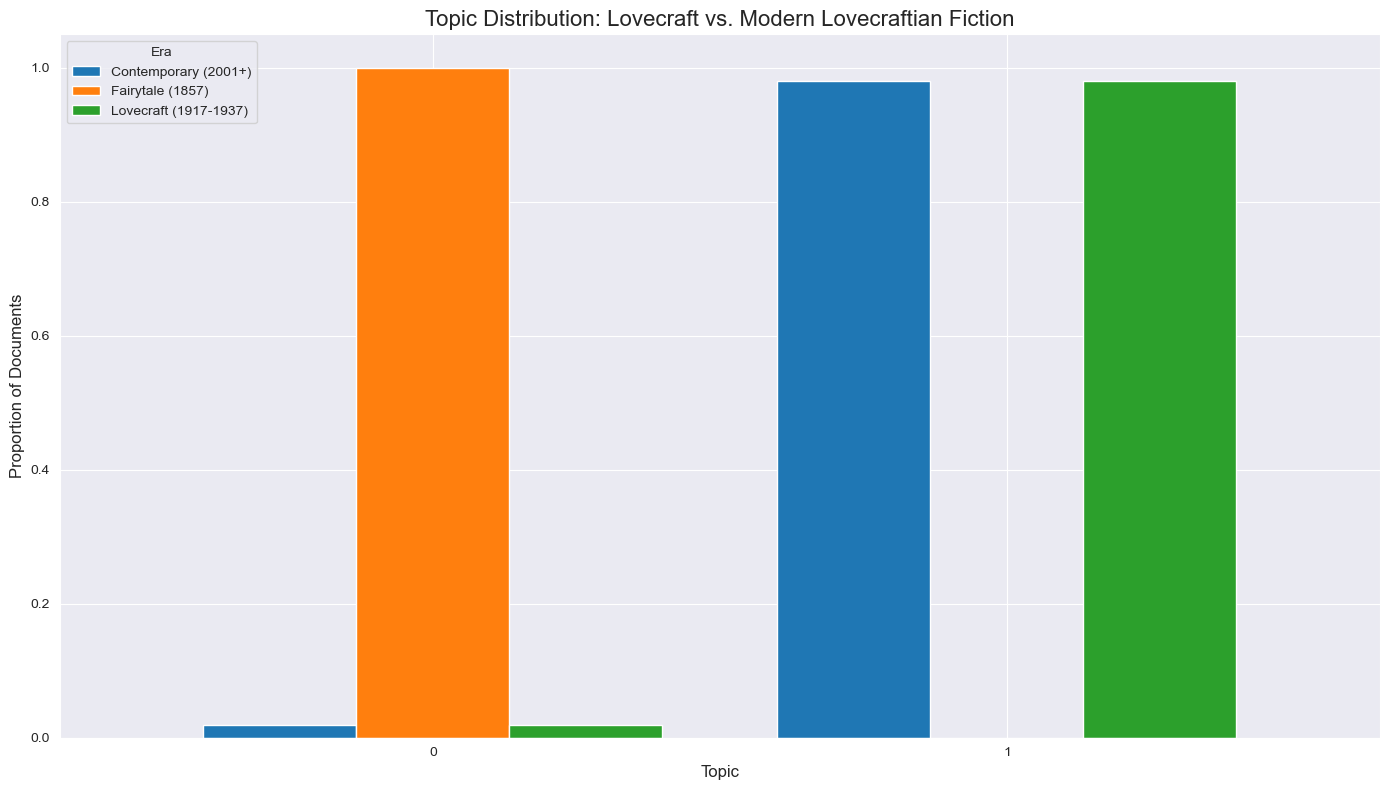


=== Topic Proportions ===
Era    Contemporary (2001+)  Fairytale (1857)  Lovecraft (1917-1937)
Topic                                                               
0                  0.019231               1.0               0.019231
1                  0.980769               0.0               0.980769


In [121]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [122]:
### Using custom stop words, hdbscan, umap ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fan_and_fiction_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fan_and_fiction_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fan_and_fiction_diversity_score = calculate_topic_diversity(fan_and_fiction_top_words)
print(f"Fan And Fiction Corpus Text Diversity Score: {fan_and_fiction_diversity_score}")

# Compute Uniqueness Score
fan_and_fiction_corpus_uniqueness, fan_and_fiction_corpus_per_topic_uniqueness = calculate_topic_uniqueness(fan_and_fiction_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fan_and_fiction_tokens_all_configs.pkl', 'fan_and_fiction_topics_all_configs.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.3724660860034322


=== Topic Information ===
   Topic  Count                            Name  \
0     -1     64     -1_cyprian_hastur_nadia_hex   
1      0     47       0_couldn_hera_maybe_dummy   
2      1     32   1_emerson_zamacona_jobe_louis   
3      2     20  2_ward_curwen_willett_hamilton   
4      3     14       3_akeley_ammi_marsh_nahum   
5      4     11  4_musides_slater_kalos_kuranes   
6      5     11    5_iranon_sarnath_aira_yalden   
7      6      9  6_gilman_jones_rogers_whateley   

                                      Representation  \
0  [cyprian, hastur, nadia, hex, kane, ghouls, al...   
1  [couldn, hera, maybe, dummy, mazlo, sam, karen...   
2  [emerson, zamacona, jobe, louis, garner, camp,...   
3  [ward, curwen, willett, hamilton, doctor, clar...   
4  [akeley, ammi, marsh, nahum, denis, marceline,...   
5  [musides, slater, kalos, kuranes, roman, grove...   
6  [iranon, sarnath, aira, yalden, barzai, atal, ...   
7  [gilman, jones, rogers, whateley, wilbur, armi...   

        

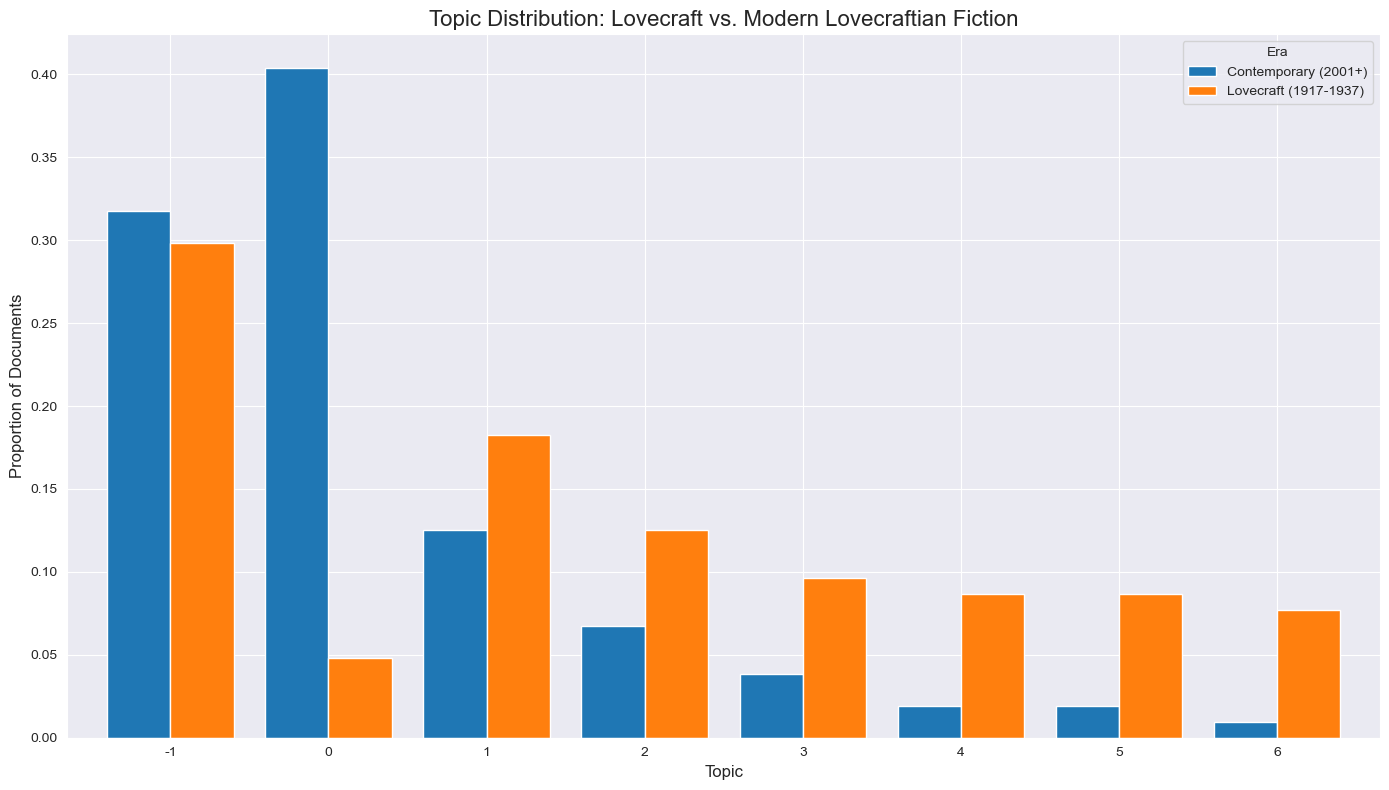


=== Topic Proportions ===
Era    Contemporary (2001+)  Lovecraft (1917-1937)
Topic                                             
-1                 0.317308               0.298077
 0                 0.403846               0.048077
 1                 0.125000               0.182692
 2                 0.067308               0.125000
 3                 0.038462               0.096154
 4                 0.019231               0.086538
 5                 0.019231               0.086538
 6                 0.009615               0.076923


In [123]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [124]:
### Using custom stop words, hdbscan ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fan_and_fiction_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fan_and_fiction_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fan_and_fiction_diversity_score = calculate_topic_diversity(fan_and_fiction_top_words)
print(f"Fan And Fiction Corpus Text Diversity Score: {fan_and_fiction_diversity_score}")

# Compute Uniqueness Score
fan_and_fiction_corpus_uniqueness, fan_and_fiction_corpus_per_topic_uniqueness = calculate_topic_uniqueness(fan_and_fiction_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fan_and_fiction_tokens_stop_words_hdbscan.pkl', 'fan_and_fiction_topics_stop_words_hdbscan.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.41538815304139


=== Topic Information ===
   Topic  Count                                  Name  \
0     -1     78        -1_ward_emerson_curwen_charles   
1      0     35                0_hera_dummy_mazlo_sam   
2      1     25            1_akeley_gilman_ammi_nahum   
3      2     16          2_zamacona_jobe_louis_garner   
4      3     16  3_hamilton_clarendon_georgina_morton   
5      4     11     4_ghouls_night gaunts_gaunts_onyx   
6      5     10          5_iranon_sarnath_aira_yalden   
7      6      9        6_dennis_calum_forrest_morgana   
8      7      8       7_innsmouth_kurtzberg_obed_aout   

                                      Representation  \
0  [ward, emerson, curwen, charles, willett, cypr...   
1  [hera, dummy, mazlo, sam, karen, darby, oskar,...   
2  [akeley, gilman, ammi, nahum, denis, marceline...   
3  [zamacona, jobe, louis, garner, camp, danforth...   
4  [hamilton, clarendon, georgina, morton, dalton...   
5  [ghouls, night gaunts, gaunts, onyx, kadath, g...   
6  [iranon

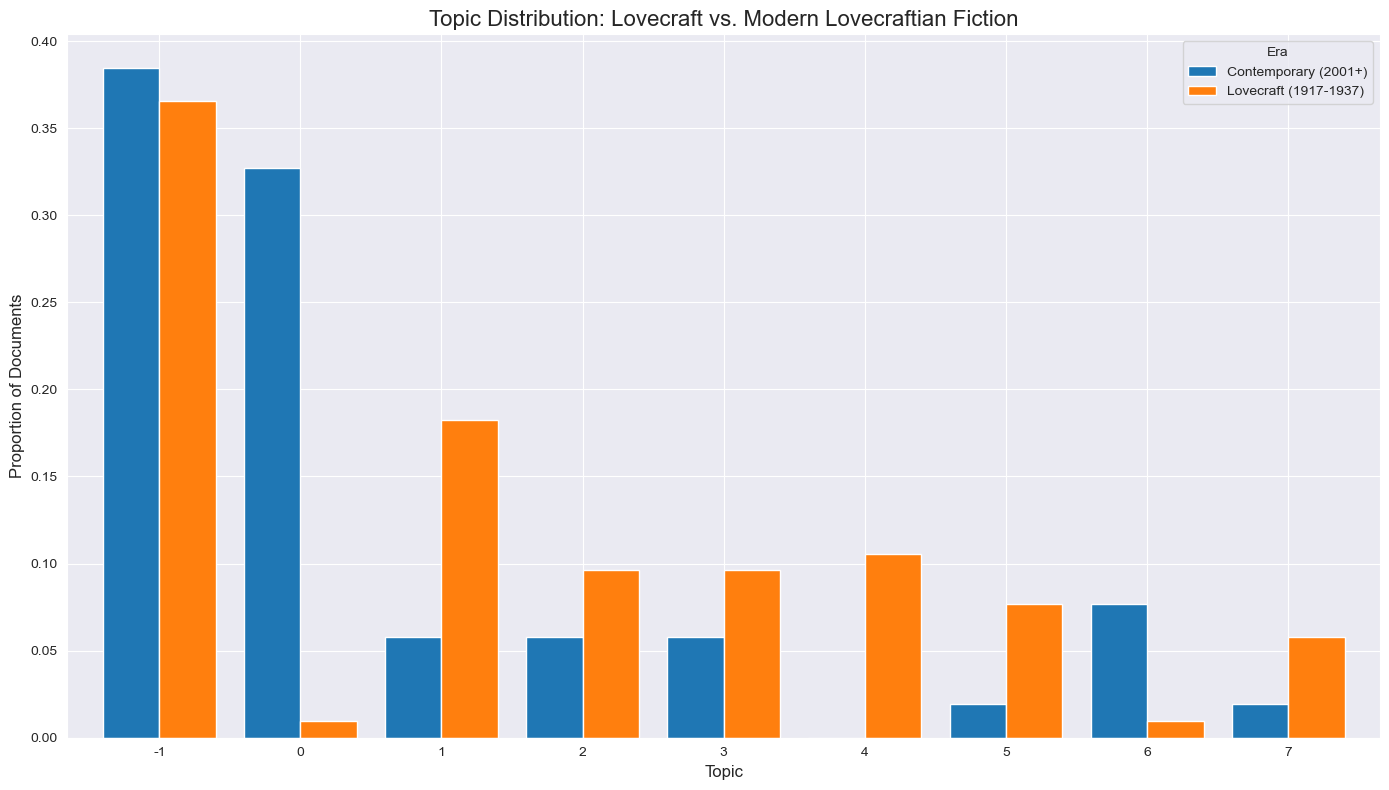


=== Topic Proportions ===
Era    Contemporary (2001+)  Lovecraft (1917-1937)
Topic                                             
-1                 0.384615               0.365385
 0                 0.326923               0.009615
 1                 0.057692               0.182692
 2                 0.057692               0.096154
 3                 0.057692               0.096154
 4                 0.000000               0.105769
 5                 0.019231               0.076923
 6                 0.076923               0.009615
 7                 0.019231               0.057692


In [125]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [126]:
### Using custom stop words, umap ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fan_and_fiction_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fan_and_fiction_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fan_and_fiction_diversity_score = calculate_topic_diversity(fan_and_fiction_top_words)
print(f"Fan And Fiction Corpus Text Diversity Score: {fan_and_fiction_diversity_score}")

# Compute Uniqueness Score
fan_and_fiction_corpus_uniqueness, fan_and_fiction_corpus_per_topic_uniqueness = calculate_topic_uniqueness(fan_and_fiction_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fan_and_fiction_tokens_stop_words_umap.pkl', 'fan_and_fiction_topics_stop_words_umap.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4264205203349266


=== Topic Information ===
   Topic  Count                               Name  \
0     -1    102      -1_ward_curwen_willett_hastur   
1      0     39            0_hera_dummy_kane_mazlo   
2      1     31      1_emerson_zamacona_jobe_louis   
3      2     25  2_night gaunts_gaunts_onyx_galley   
4      3     11      3_gilman_rogers_carson_elwood   

                                      Representation  \
0  [ward, curwen, willett, hastur, cyprian, akele...   
1  [hera, dummy, kane, mazlo, karen, darby, billy...   
2  [emerson, zamacona, jobe, louis, garner, camp,...   
3  [night gaunts, gaunts, onyx, galley, great one...   
4  [gilman, rogers, carson, elwood, harington, or...   

                                             KeyBERT  \
0  [mummy, prison, wilbur, charles ward, gaston, ...   
1  [ventriloquism, greater ventriloquism, welles,...   
2  [insurgents, antarctic, archaean, planes, tent...   
3  [earth gods, pnakotic manuscripts, monastery, ...   
4  [torment, countenance, abnor

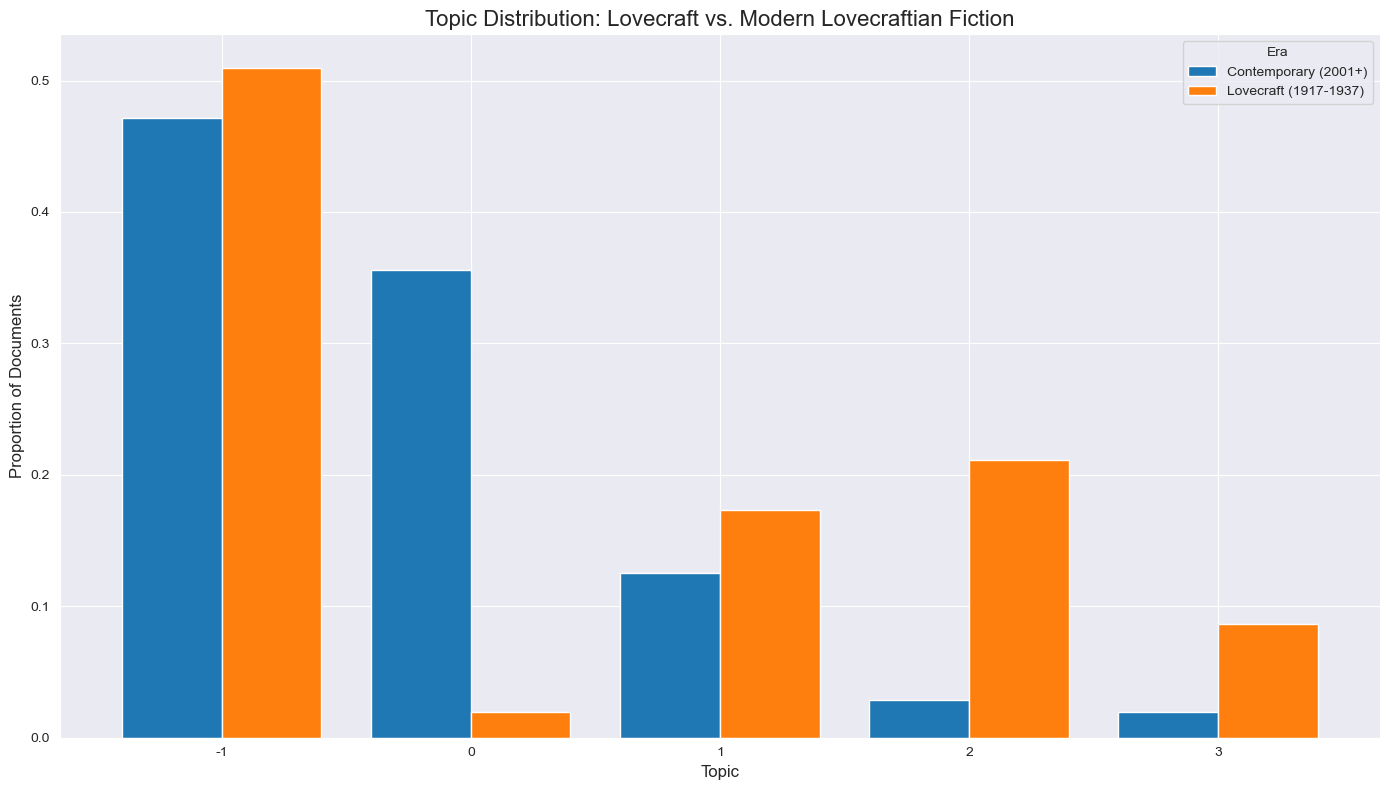


=== Topic Proportions ===
Era    Contemporary (2001+)  Lovecraft (1917-1937)
Topic                                             
-1                 0.471154               0.509615
 0                 0.355769               0.019231
 1                 0.125000               0.173077
 2                 0.028846               0.211538
 3                 0.019231               0.086538


In [127]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [128]:
### Using custom stop words only ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
fan_and_fiction_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        fan_and_fiction_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
fan_and_fiction_diversity_score = calculate_topic_diversity(fan_and_fiction_top_words)
print(f"Fan And Fiction Corpus Text Diversity Score: {fan_and_fiction_diversity_score}")

# Compute Uniqueness Score
fan_and_fiction_corpus_uniqueness, fan_and_fiction_corpus_per_topic_uniqueness = calculate_topic_uniqueness(fan_and_fiction_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'fan_and_fiction_tokens_stop_words.pkl', 'fan_and_fiction_topics_stop_words.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.39293744030094546


=== Topic Information ===
   Topic  Count                                 Name  \
0     -1    110     -1_charles_curwen_willett_hastur   
1      0     31        0_emerson_zamacona_jobe_louis   
2      1     30  1_ghouls_gaunts_night gaunts_galley   
3      2     26             2_hera_dummy_mazlo_darby   
4      3     11           3_kane_karen_welles_edward   

                                      Representation  \
0  [charles, curwen, willett, hastur, cyprian, ye...   
1  [emerson, zamacona, jobe, louis, garner, camp,...   
2  [ghouls, gaunts, night gaunts, galley, great o...   
3  [hera, dummy, mazlo, darby, billy, ava, lenora...   
4  [kane, karen, welles, edward, asenath, ray, le...   

                                             KeyBERT  \
0  [mummy, wilbur, gaston, charles ward, charles,...   
1  [insurgents, antarctic, planes, expedition, ma...   
2  [waking world, dreamland, earth gods, palaces,...   
3  [ventriloquism, greater ventriloquism, ventril...   
4  [asylum, welles,

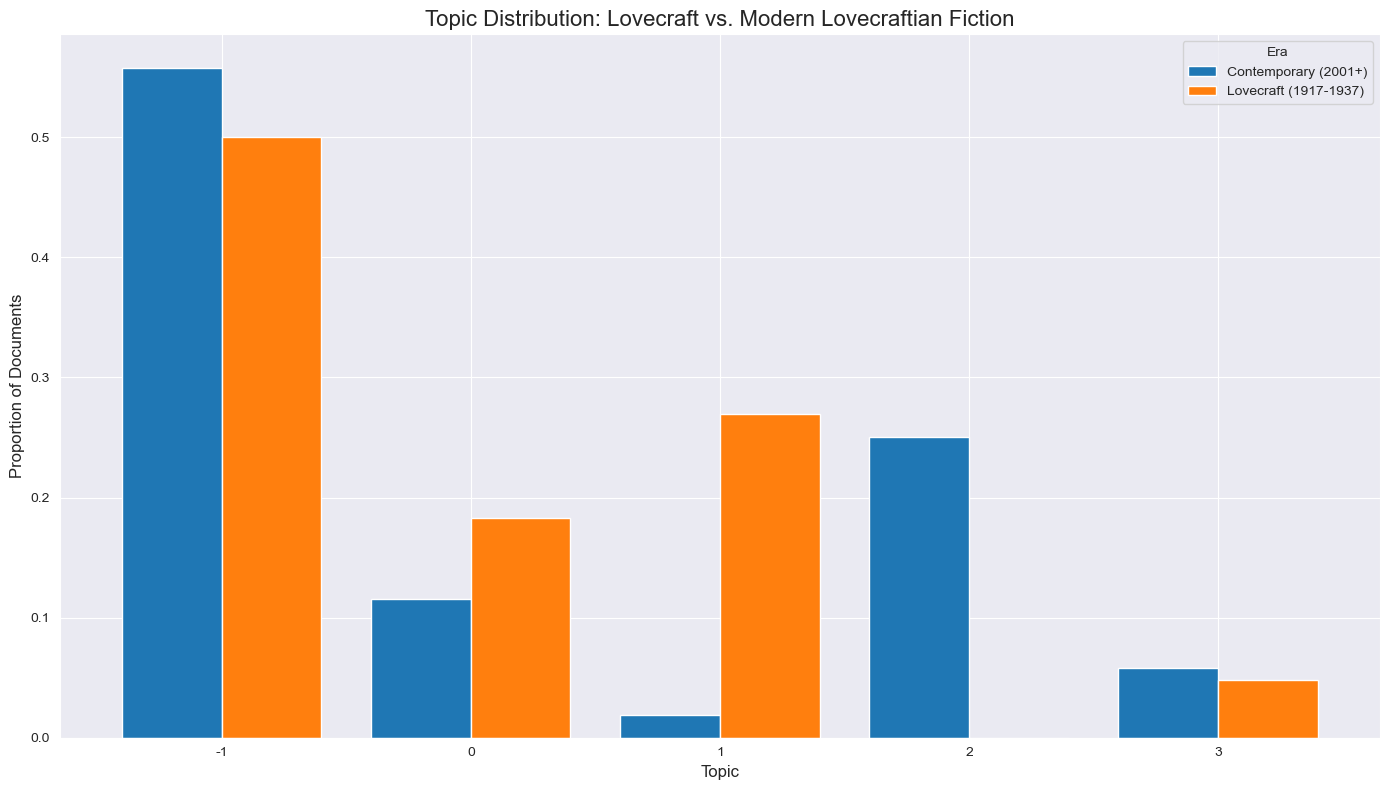


=== Topic Proportions ===
Era    Contemporary (2001+)  Lovecraft (1917-1937)
Topic                                             
-1                 0.557692               0.500000
 0                 0.115385               0.182692
 1                 0.019231               0.269231
 2                 0.250000               0.000000
 3                 0.057692               0.048077


In [129]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [130]:
### Using custom stop words, hdbscan, umap ###
df = convert_text_files(directories=['./GrimmFairyTaleAgain/', './fiction_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_and_fiction_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_and_fiction_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_fairy_tale_and_fiction_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_and_fiction_corpus_top_words)
print(f"Grimm FairyTale Again and Fiction Text Diversity Score: {grimm_again_fairy_tale_and_fiction_diversity_score}")

# Compute Uniqueness Score
grimm_again_fairy_tale_and_fiction_corpus_uniqueness, grimm_fairy_tale_and_fiction_corpus_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_and_fiction_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_and_fiction_tokens_all_configs.pkl', 'grimm_again_and_fiction_topics_all_configs.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4171836650812356


=== Topic Information ===
   Topic  Count                                    Name  \
0     -1     73           -1_ancient_akeley_gods_tailor   
1      0     73  0_huntsman_king daughter_tailor_hansel   
2      1     61           1_ward_curwen_willett_ancient   

                                      Representation  \
0  [ancient, akeley, gods, tailor, ghouls, jones,...   
1  [huntsman, king daughter, tailor, hansel, thum...   
2  [ward, curwen, willett, ancient, charles, ye, ...   

                                             KeyBERT  \
0  [consciousness, tales, chaos, imagination, mys...   
1  [huntsmen, huntsman, fisherman, feathers, goos...   
2  [history, consciousness, specimens, ancient, m...   

                                                 MMR  \
0  [vast, tales, museum, nameless, arkham, sinist...   
1  [tailor, hansel, huntsmen, hedgehog, cinderell...   
2  [vast, library, specimens, consciousness, what...   

                                 Representative_Docs  
0  [Du

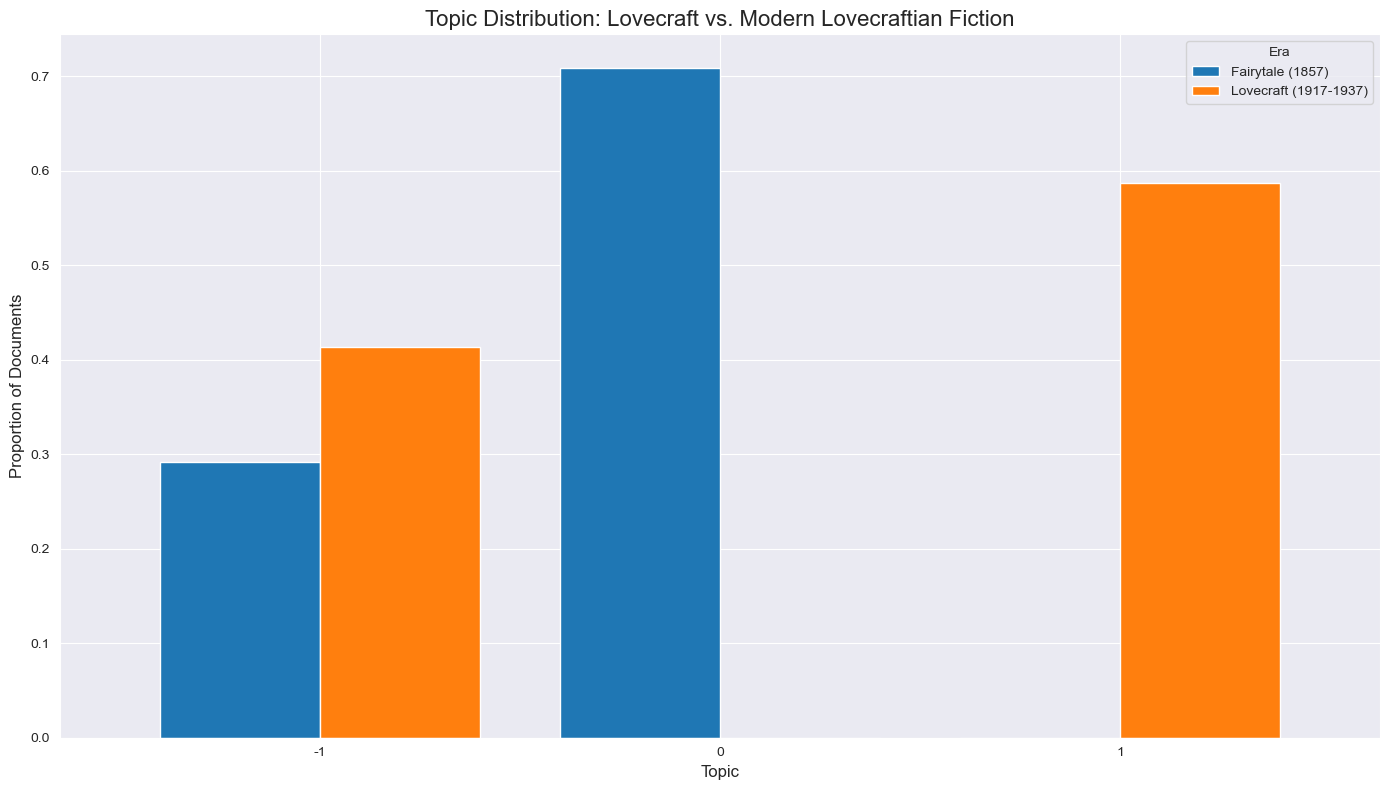


=== Topic Proportions ===
Era    Fairytale (1857)  Lovecraft (1917-1937)
Topic                                         
-1             0.291262               0.413462
 0             0.708738               0.000000
 1             0.000000               0.586538


In [131]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [132]:
### Using custom stop words, hdbscan ###
df = convert_text_files(directories=['./GrimmFairyTaleAgain/', './fiction_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_and_fiction_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_and_fiction_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_fairy_tale_and_fiction_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_and_fiction_corpus_top_words)
print(f"Grimm FairyTale Again and Fiction Text Diversity Score: {grimm_again_fairy_tale_and_fiction_diversity_score}")

# Compute Uniqueness Score
grimm_again_fairy_tale_and_fiction_corpus_uniqueness, grimm_fairy_tale_and_fiction_corpus_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_and_fiction_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_and_fiction_tokens_stop_words_hdbscan.pkl', 'grimm_again_and_fiction_topics_stop_words_hdbscan.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.3594067916345416


=== Topic Information ===
   Topic  Count                                  Name  \
0     -1     53         -1_tailor_gretel_blake_lustig   
1      0     89                0_ancient_ward_vast_ye   
2      1     65  1_huntsman_king daughter_tailor_lion   

                                      Representation  \
0  [tailor, gretel, blake, lustig, brother lustig...   
1  [ancient, ward, vast, ye, wholly, gods, curwen...   
2  [huntsman, king daughter, tailor, lion, hare, ...   

                                             KeyBERT  \
0  [tale, tales, stricken, cthulhu, grotesque, im...   
1  [ancient, consciousness, specimens, grotesque,...   
2  [huntsmen, huntsman, fisherman, awakening, har...   

                                                 MMR  \
0  [gretel, hedgehog, ermengarde, cthulhu, manusc...   
1  [vast, nameless, arkham, sinister, tales, abys...   
2  [thumbling, huntsmen, onwards, flower, eat dri...   

                                 Representative_Docs  
0  [A little a

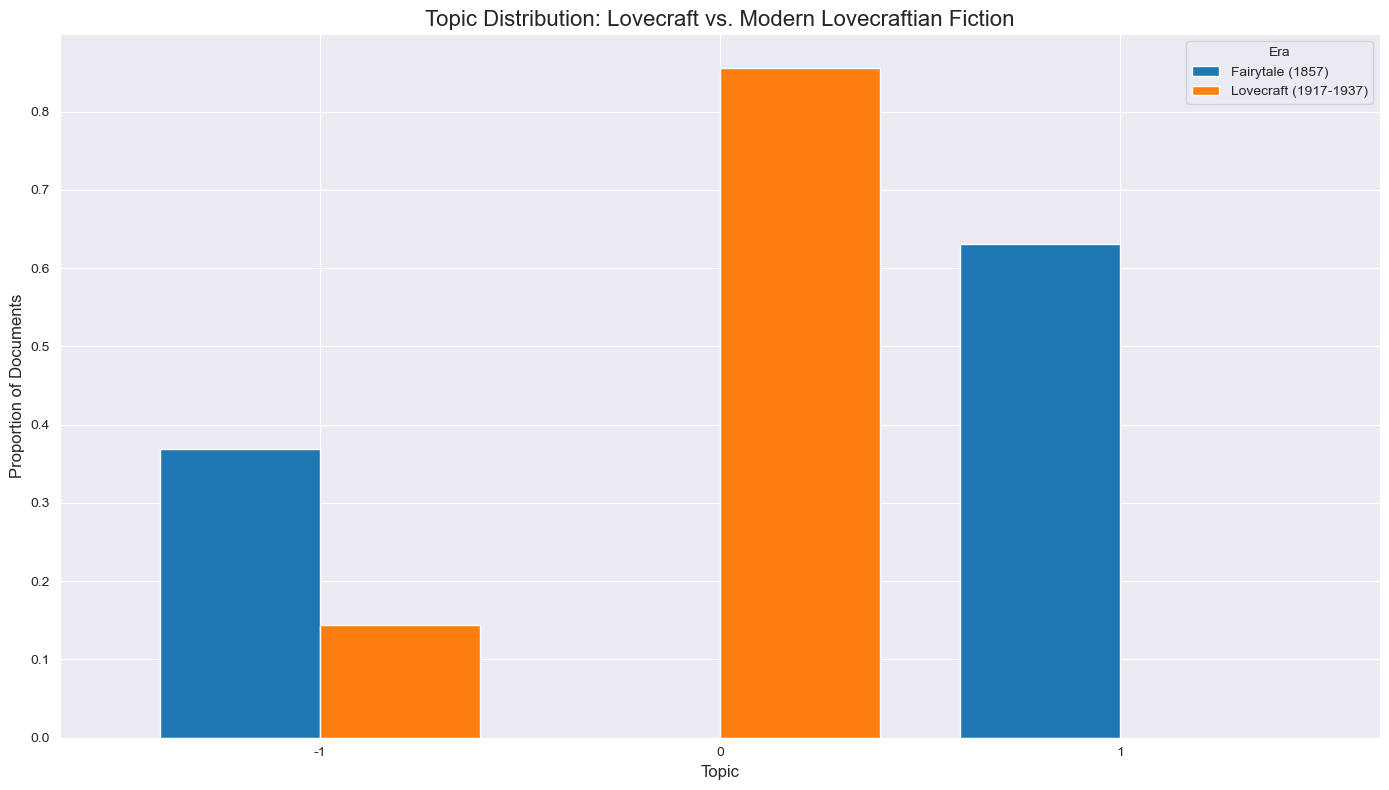


=== Topic Proportions ===
Era    Fairytale (1857)  Lovecraft (1917-1937)
Topic                                         
-1             0.368932               0.144231
 0             0.000000               0.855769
 1             0.631068               0.000000


In [133]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [134]:
### Using custom stop words, umap ###
df = convert_text_files(directories=['./GrimmFairyTaleAgain/', './fiction_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_and_fiction_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_and_fiction_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_fairy_tale_and_fiction_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_and_fiction_corpus_top_words)
print(f"Grimm FairyTale Again and Fiction Text Diversity Score: {grimm_again_fairy_tale_and_fiction_diversity_score}")

# Compute Uniqueness Score
grimm_again_fairy_tale_and_fiction_corpus_uniqueness, grimm_fairy_tale_and_fiction_corpus_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_and_fiction_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_and_fiction_tokens_stop_words_umap.pkl', 'grimm_again_and_fiction_topics_stop_words_umap.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.37264331869634776


=== Topic Information ===
   Topic  Count                                    Name  \
0      0    104  0_tailor_king daughter_huntsman_gretel   
1      1    103                 1_ward_vast_wholly_gods   

                                      Representation  \
0  [tailor, king daughter, huntsman, gretel, lust...   
1  [ward, vast, wholly, gods, despite, nameless, ...   

                                             KeyBERT  \
0  [huntsmen, huntsman, dwarfs, goose, hansel, ci...   
1  [consciousness, specimens, grotesque, imaginat...   

                                                 MMR  \
0  [tailor, gretel, hansel, hedgehog, cinderella,...   
1  [vast, arkham, sinister, tales, consciousness,...   

                                 Representative_Docs  
0  [There was once a man who understood all kinds...  
1  [“The essential Saltes of Animals may be so pr...  

Topic 0:
[('tailor', 0.49708149765176285), ('king daughter', 0.4141750644592999), ('huntsman', 0.4023191949282858), ('gret

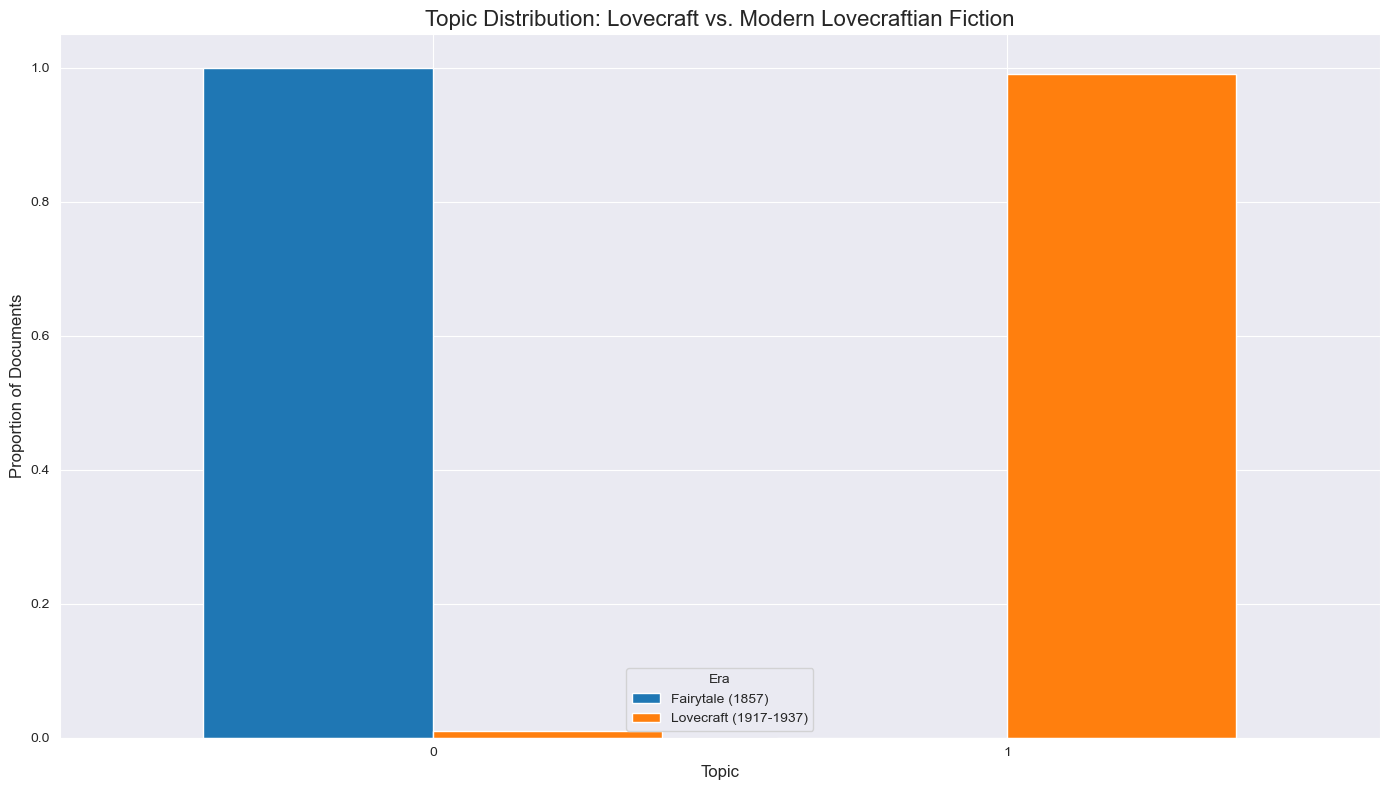


=== Topic Proportions ===
Era    Fairytale (1857)  Lovecraft (1917-1937)
Topic                                         
0                   1.0               0.009615
1                   0.0               0.990385


In [135]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [136]:
### Using custom stop words only ###
df = convert_text_files(directories=['./GrimmFairyTaleAgain/', './fiction_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_and_fiction_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_and_fiction_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_fairy_tale_and_fiction_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_and_fiction_corpus_top_words)
print(f"Grimm FairyTale Again and Fiction Text Diversity Score: {grimm_again_fairy_tale_and_fiction_diversity_score}")

# Compute Uniqueness Score
grimm_again_fairy_tale_and_fiction_corpus_uniqueness, grimm_fairy_tale_and_fiction_corpus_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_and_fiction_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_and_fiction_tokens_stop_words.pkl', 'grimm_again_and_fiction_topics_stop_words.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.37264331869634776


=== Topic Information ===
   Topic  Count                                    Name  \
0      0    104  0_tailor_king daughter_huntsman_gretel   
1      1    103                 1_ward_vast_wholly_gods   

                                      Representation  \
0  [tailor, king daughter, huntsman, gretel, lust...   
1  [ward, vast, wholly, gods, despite, nameless, ...   

                                             KeyBERT  \
0  [huntsmen, huntsman, dwarfs, goose, hansel, ci...   
1  [consciousness, specimens, grotesque, imaginat...   

                                                 MMR  \
0  [tailor, gretel, hansel, hedgehog, cinderella,...   
1  [vast, arkham, sinister, tales, consciousness,...   

                                 Representative_Docs  
0  [There was once a man who understood all kinds...  
1  [“The essential Saltes of Animals may be so pr...  

Topic 0:
[('tailor', 0.49708149765176285), ('king daughter', 0.4141750644592999), ('huntsman', 0.4023191949282858), ('gret

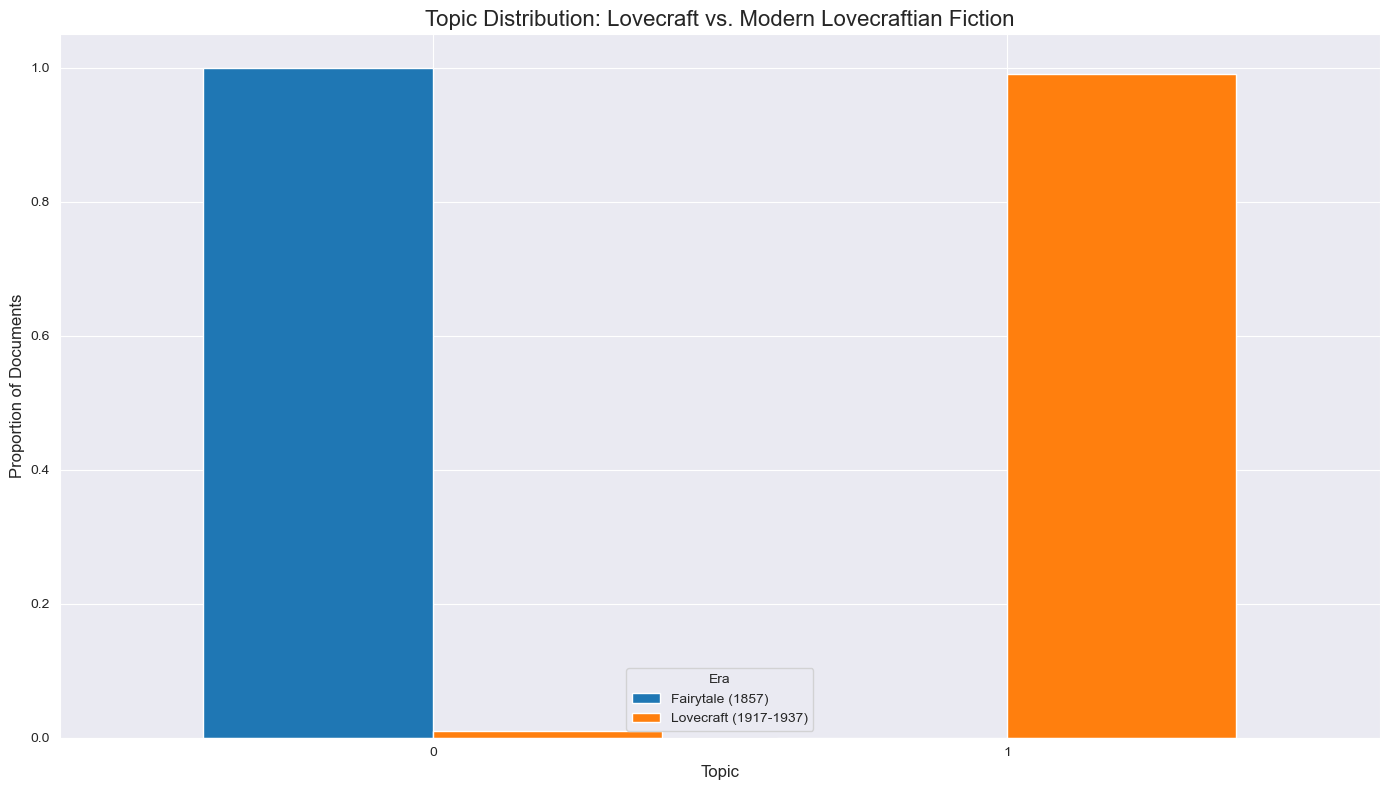


=== Topic Proportions ===
Era    Fairytale (1857)  Lovecraft (1917-1937)
Topic                                         
0                   1.0               0.009615
1                   0.0               0.990385


In [137]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [138]:
### Using custom stop words, hdbscan, umap ###

df = convert_text_files(directories=['./GrimmFairyTaleAgain/', './Fan_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_and_fan_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_and_fan_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_fairy_tale_and_fan_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_and_fan_corpus_top_words)
print(f"Grimm Again FairyTale and Fan Text Diversity Score: {grimm_again_fairy_tale_and_fan_diversity_score}")

# Compute Uniqueness Score
grimm_again_fairy_tale_and_fan_corpus_uniqueness, grimm_again_fairy_tale_and_fan_corpus_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_and_fan_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_and_fan_tokens_all_configs.pkl', 'grimm_again_and_fan_topics_all_configs.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.44189133607965725


=== Topic Information ===
   Topic  Count                                   Name  \
0     -1     62        -1_cyprian_hamilton_kane_garner   
1      0     49             0_hastur_couldn_hera_dummy   
2      1     24          1_tailor_hans_thumbling_giant   
3      2     17               2_hex_alejo_noolan_ricou   
4      3     16    3_faithful john_faithful_john_bride   
5      4     11    4_hansel_gretel_marlinchen_rapunzel   
6      5     10             5_emerson_jobe_louis_myles   
7      6      9  6_snow white_cinderella_elsie_red cap   
8      7      9             7_huntsman_fox_lion_dragon   

                                      Representation  \
0  [cyprian, hamilton, kane, garner, nadia, wolf,...   
1  [hastur, couldn, hera, dummy, maybe, mazlo, sa...   
2  [tailor, hans, thumbling, giant, hedgehog, shu...   
3  [hex, alejo, noolan, ricou, dennis, calum, har...   
4  [faithful john, faithful, john, bride, hare, p...   
5  [hansel, gretel, marlinchen, rapunzel, juniper...   


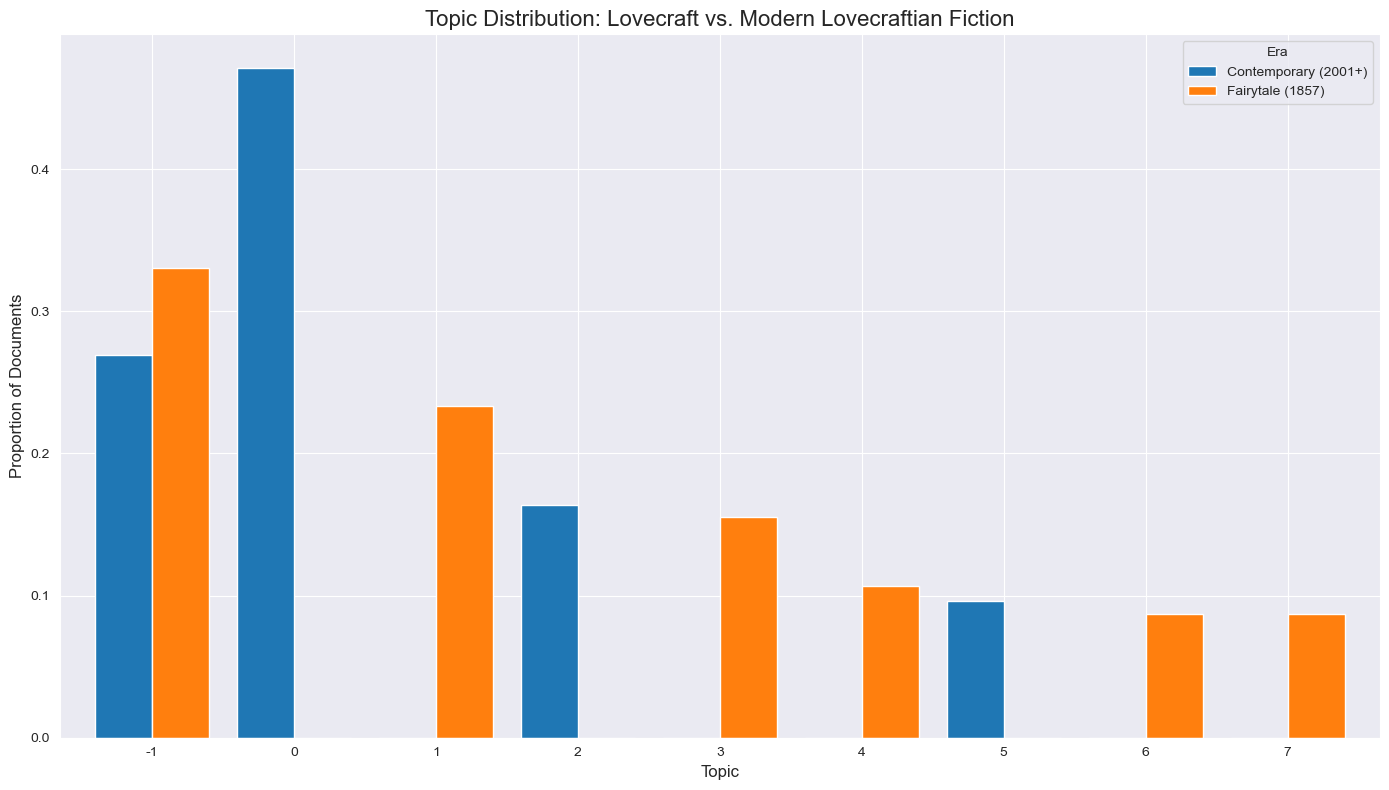


=== Topic Proportions ===
Era    Contemporary (2001+)  Fairytale (1857)
Topic                                        
-1                 0.269231          0.330097
 0                 0.471154          0.000000
 1                 0.000000          0.233010
 2                 0.163462          0.000000
 3                 0.000000          0.155340
 4                 0.000000          0.106796
 5                 0.096154          0.000000
 6                 0.000000          0.087379
 7                 0.000000          0.087379


In [139]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [140]:
### Using custom stop words, hdbscan ###

df = convert_text_files(directories=['./GrimmFairyTaleAgain/', './Fan_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_and_fan_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_and_fan_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_fairy_tale_and_fan_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_and_fan_corpus_top_words)
print(f"Grimm Again FairyTale and Fan Text Diversity Score: {grimm_again_fairy_tale_and_fan_diversity_score}")

# Compute Uniqueness Score
grimm_again_fairy_tale_and_fan_corpus_uniqueness, grimm_again_fairy_tale_and_fan_corpus_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_and_fan_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_and_fan_tokens_stop_words_hdbscan.pkl', 'grimm_again_and_fan_topics_stop_words_hdbscan.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.47247022586790377


=== Topic Information ===
   Topic  Count                                             Name  \
0     -1     72               -1_emerson_hastur_cyprian_hamilton   
1      0     48              0_tailor_lustig_brother lustig_goat   
2      1     41                           1_hera_mazlo_maybe_sam   
3      2     29  2_huntsman_king daughter_faithful_faithful john   
4      3     17                        3_hex_noolan_ricou_dennis   

                                      Representation  \
0  [emerson, hastur, cyprian, hamilton, nadia, jo...   
1  [tailor, lustig, brother lustig, goat, thumbli...   
2  [hera, mazlo, maybe, sam, karen, darby, oskar,...   
3  [huntsman, king daughter, faithful, faithful j...   
4  [hex, noolan, ricou, dennis, calum, harfarger,...   

                                             KeyBERT  \
0  [sergeant, military, mission, mask, police, ar...   
1  [beggar, pig, misfortune, merry, clever elsie,...   
2  [office, victim, paper, knowledge, memories, a...   
3  

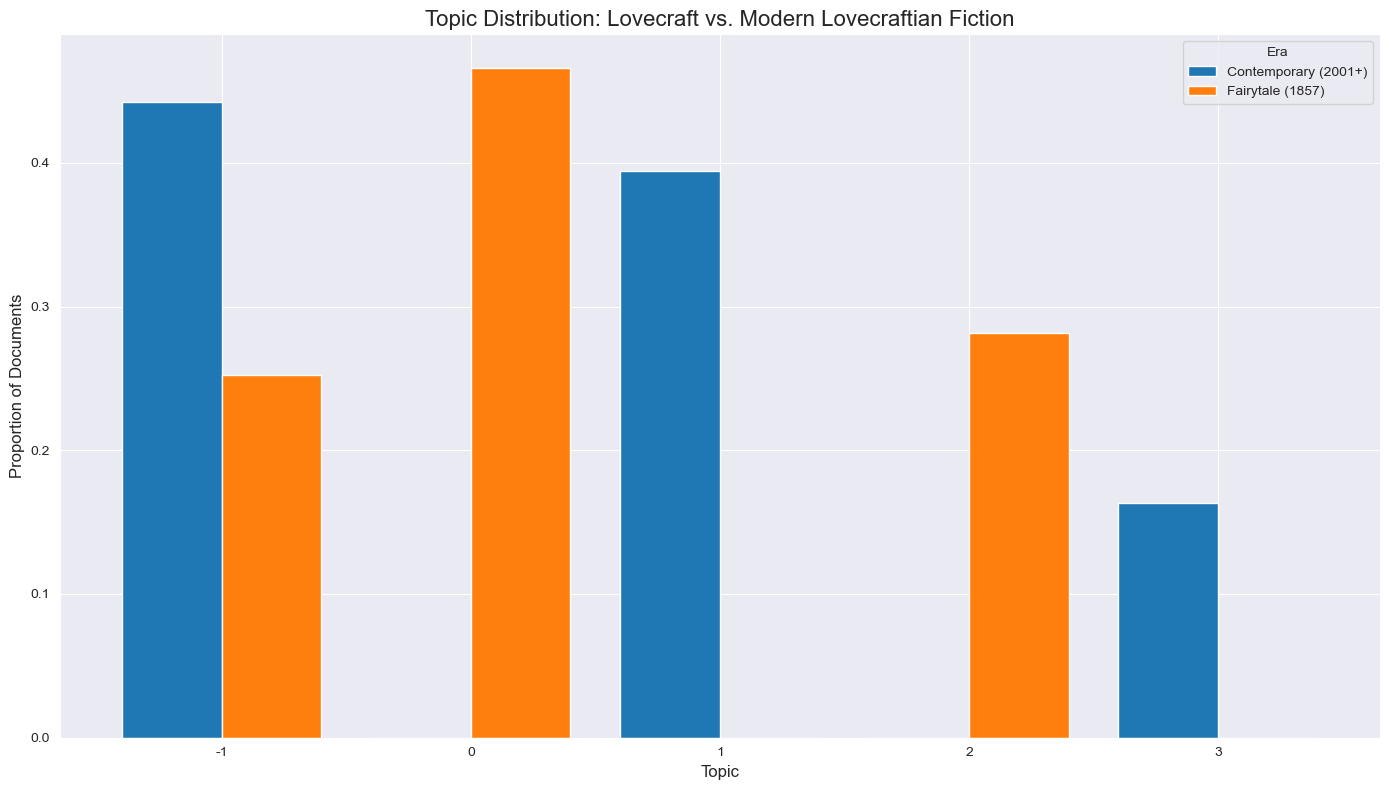


=== Topic Proportions ===
Era    Contemporary (2001+)  Fairytale (1857)
Topic                                        
-1                 0.442308          0.252427
 0                 0.000000          0.466019
 1                 0.394231          0.000000
 2                 0.000000          0.281553
 3                 0.163462          0.000000


In [141]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [142]:
### Using custom stop words, umap ###

df = convert_text_files(directories=['./GrimmFairyTaleAgain/', './Fan_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_and_fan_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_and_fan_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_fairy_tale_and_fan_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_and_fan_corpus_top_words)
print(f"Grimm Again FairyTale and Fan Text Diversity Score: {grimm_again_fairy_tale_and_fan_diversity_score}")

# Compute Uniqueness Score
grimm_again_fairy_tale_and_fan_corpus_uniqueness, grimm_again_fairy_tale_and_fan_corpus_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_and_fan_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_and_fan_tokens_stop_words_umap.pkl', 'grimm_again_and_fan_topics_stop_words_umap.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4539372437862932


=== Topic Information ===
   Topic  Count                                      Name  \
0      0    104               0_emerson_maybe_hadn_hastur   
1      1    103  1_tailor_king daughter_huntsman_king son   

                                      Representation  \
0  [emerson, maybe, hadn, hastur, cyprian, wouldn...   
1  [tailor, king daughter, huntsman, king son, gr...   

                                             KeyBERT  \
0  [shadows, shadow, history, police, mask, ahead...   
1  [huntsmen, seven dwarfs, dwarfs, hansel, hunts...   

                                                 MMR  \
0  [emerson, wouldn, jobe, simon, wilmarth, profe...   
1  [tailor, hansel, bridegroom, merry, cinderella...   

                                 Representative_Docs  
0  [Gaston Morrell was drowning, The waters of th...  
1  [There was once a man who understood all kinds...  

Topic 0:
[('emerson', 0.02361732358268409), ('maybe', 0.023534205389951268), ('hadn', 0.020035057159009433), ('hastu

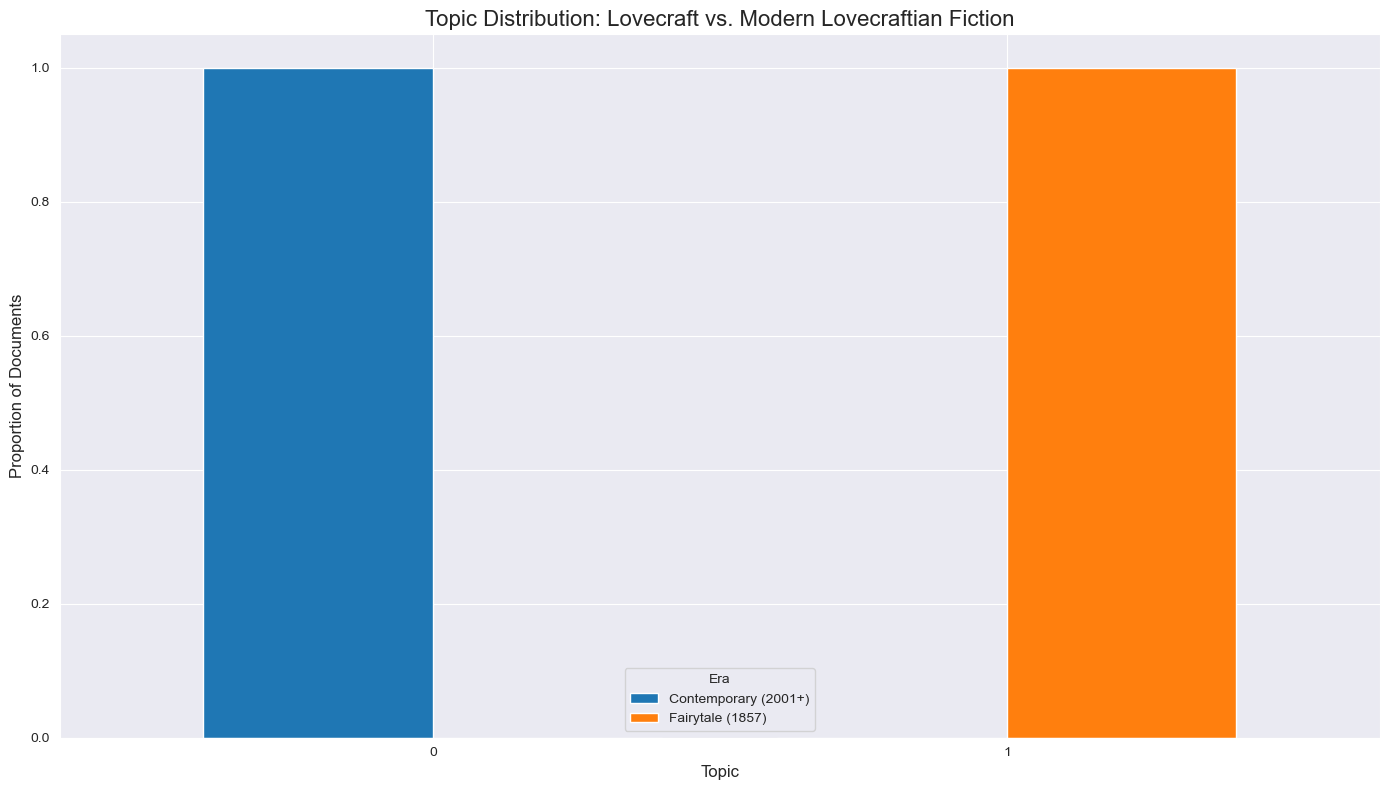


=== Topic Proportions ===
Era    Contemporary (2001+)  Fairytale (1857)
Topic                                        
0                       1.0               0.0
1                       0.0               1.0


In [143]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [144]:
### Using custom stop words only ###

df = convert_text_files(directories=['./GrimmFairyTaleAgain/', './Fan_text_files/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
grimm_again_fairy_tale_and_fan_corpus_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        grimm_again_fairy_tale_and_fan_corpus_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
grimm_again_fairy_tale_and_fan_diversity_score = calculate_topic_diversity(grimm_again_fairy_tale_and_fan_corpus_top_words)
print(f"Grimm Again FairyTale and Fan Text Diversity Score: {grimm_again_fairy_tale_and_fan_diversity_score}")

# Compute Uniqueness Score
grimm_again_fairy_tale_and_fan_corpus_uniqueness, grimm_again_fairy_tale_and_fan_corpus_per_topic_uniqueness = calculate_topic_uniqueness(grimm_again_fairy_tale_and_fan_corpus_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'grimm_again_and_fan_tokens_stop_words.pkl', 'grimm_again_and_fan_topics_stop_words.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.4539372437862932


=== Topic Information ===
   Topic  Count                                      Name  \
0      0    104               0_emerson_maybe_hadn_hastur   
1      1    103  1_tailor_king daughter_huntsman_king son   

                                      Representation  \
0  [emerson, maybe, hadn, hastur, cyprian, wouldn...   
1  [tailor, king daughter, huntsman, king son, gr...   

                                             KeyBERT  \
0  [shadows, shadow, history, police, mask, ahead...   
1  [huntsmen, seven dwarfs, dwarfs, hansel, hunts...   

                                                 MMR  \
0  [emerson, wouldn, jobe, simon, wilmarth, profe...   
1  [tailor, hansel, bridegroom, merry, cinderella...   

                                 Representative_Docs  
0  [Gaston Morrell was drowning, The waters of th...  
1  [There was once a man who understood all kinds...  

Topic 0:
[('emerson', 0.02361732358268409), ('maybe', 0.023534205389951268), ('hadn', 0.020035057159009433), ('hastu

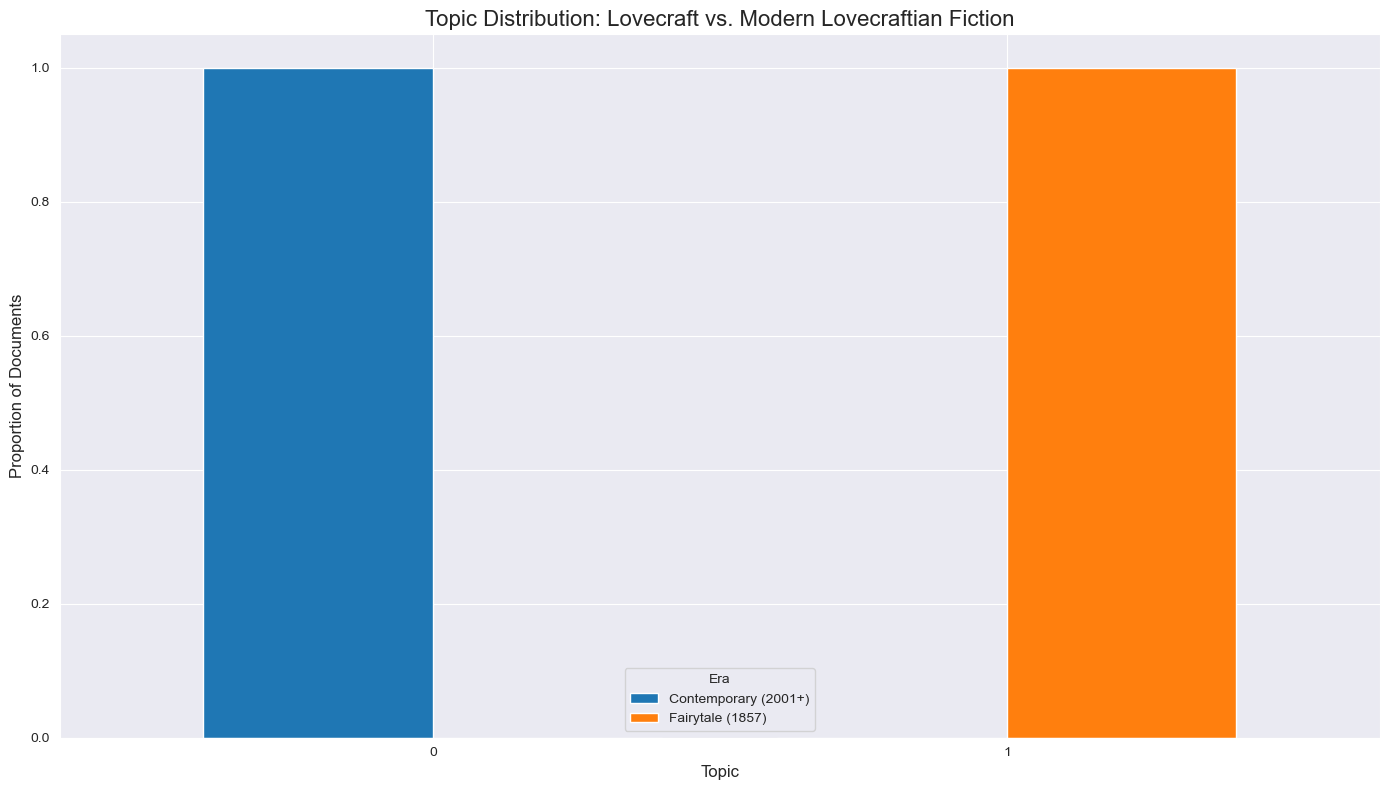


=== Topic Proportions ===
Era    Contemporary (2001+)  Fairytale (1857)
Topic                                        
0                       1.0               0.0
1                       0.0               1.0


In [145]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [146]:
### Using custom stop words, hdbscan, umap ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/','./GrimmFairyTaleAgain/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
all_corpus_again_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        all_corpus_again_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
all_corpus_again_diversity_score = calculate_topic_diversity(all_corpus_again_top_words)
print(f"All Corpus with Grimm Again Diversity Score: {all_corpus_again_diversity_score}")

# Compute Uniqueness Score
all_corpus_again_uniqueness, all_corpus_again_per_topic_uniqueness = calculate_topic_uniqueness(all_corpus_again_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'all_corpus_again_tokens_all_configs.pkl', 'all_corpus_again_topics_all_configs.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.376860428941195


=== Topic Information ===
   Topic  Count                            Name  \
0     -1    117   -1_ward_charles_curwen_doctor   
1      0    113    0_ancient_couldn_vast_hastur   
2      1     69  1_brother_maiden_huntsman_hans   
3      2     12  2_emerson_innsmouth_myles_amye   

                                      Representation  \
0  [ward, charles, curwen, doctor, willett, cypri...   
1  [ancient, couldn, vast, hastur, metal, hills, ...   
2  [brother, maiden, huntsman, hans, castle, brot...   
3  [emerson, innsmouth, myles, amye, damien, broo...   

                                             KeyBERT  \
0  [corpse, welles, ancient, coffin, ghouls, muse...   
1  [history, consciousness, tales, ancient, alien...   
2  [huntsmen, servants, feathers, egg, kingdom, k...   
3  [marine, sergeant, lieutenant, officer, missio...   

                                                 MMR  \
0  [ward, ghouls, wilmarth, library, welles, name...   
1  [vast, nameless, knowledge, tales, abyss

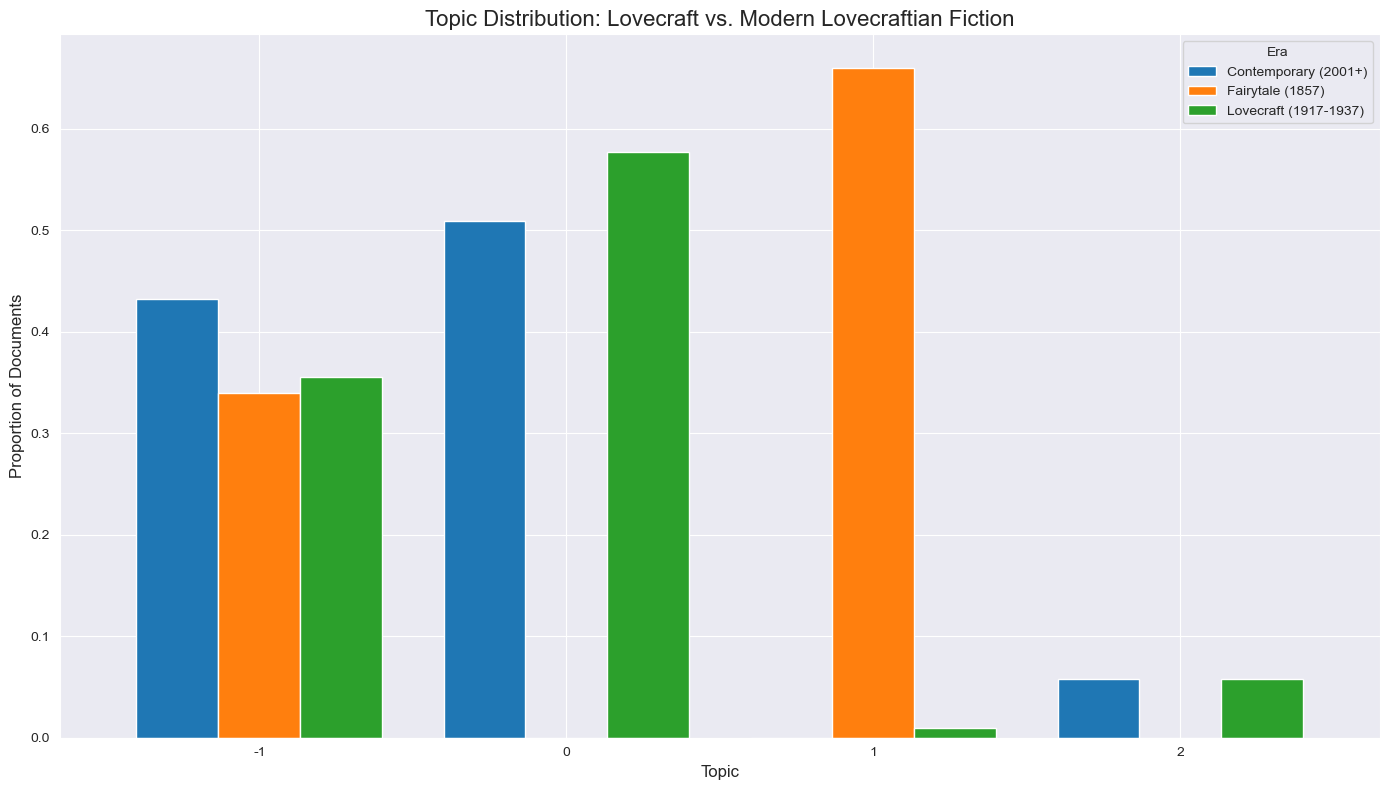


=== Topic Proportions ===
Era    Contemporary (2001+)  Fairytale (1857)  Lovecraft (1917-1937)
Topic                                                               
-1                 0.432692          0.339806               0.355769
 0                 0.509615          0.000000               0.576923
 1                 0.000000          0.660194               0.009615
 2                 0.057692          0.000000               0.057692


In [147]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [148]:
### Using custom stop words, hdbscan ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/','./GrimmFairyTaleAgain/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=True, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
all_corpus_again_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        all_corpus_again_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
all_corpus_again_diversity_score = calculate_topic_diversity(all_corpus_again_top_words)
print(f"All Corpus with Grimm Again Diversity Score: {all_corpus_again_diversity_score}")

# Compute Uniqueness Score
all_corpus_again_uniqueness, all_corpus_again_per_topic_uniqueness = calculate_topic_uniqueness(all_corpus_again_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'all_corpus_again_tokens_stop_words_hdbscan.pkl', 'all_corpus_again_topics_stop_words_hdbscan.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.40342559514549475


=== Topic Information ===
   Topic  Count                                Name  \
0     -1     94           -1_hastur_tailor_hex_kane   
1      0    142           0_ancient_space_ward_vast   
2      1     62  1_brother_maiden_huntsman_brothers   
3      2     13      2_emerson_innsmouth_myles_amye   

                                      Representation  \
0  [hastur, tailor, hex, kane, hans, nadia, cypri...   
1  [ancient, space, ward, vast, doctor, couldn, w...   
2  [brother, maiden, huntsman, brothers, castle, ...   
3  [emerson, innsmouth, myles, amye, damien, broo...   

                                             KeyBERT  \
0  [museum, grimoire, shadows, welles, painting, ...   
1  [history, ancient, consciousness, tales, abyss...   
2  [huntsmen, kingdom, cinderella, servants, brot...   
3  [military, marine, sergeant, officer, mission,...   

                                                 MMR  \
0  [morrell, welles, museum, gods, gallowglass, s...   
1  [vast, nameless, kno

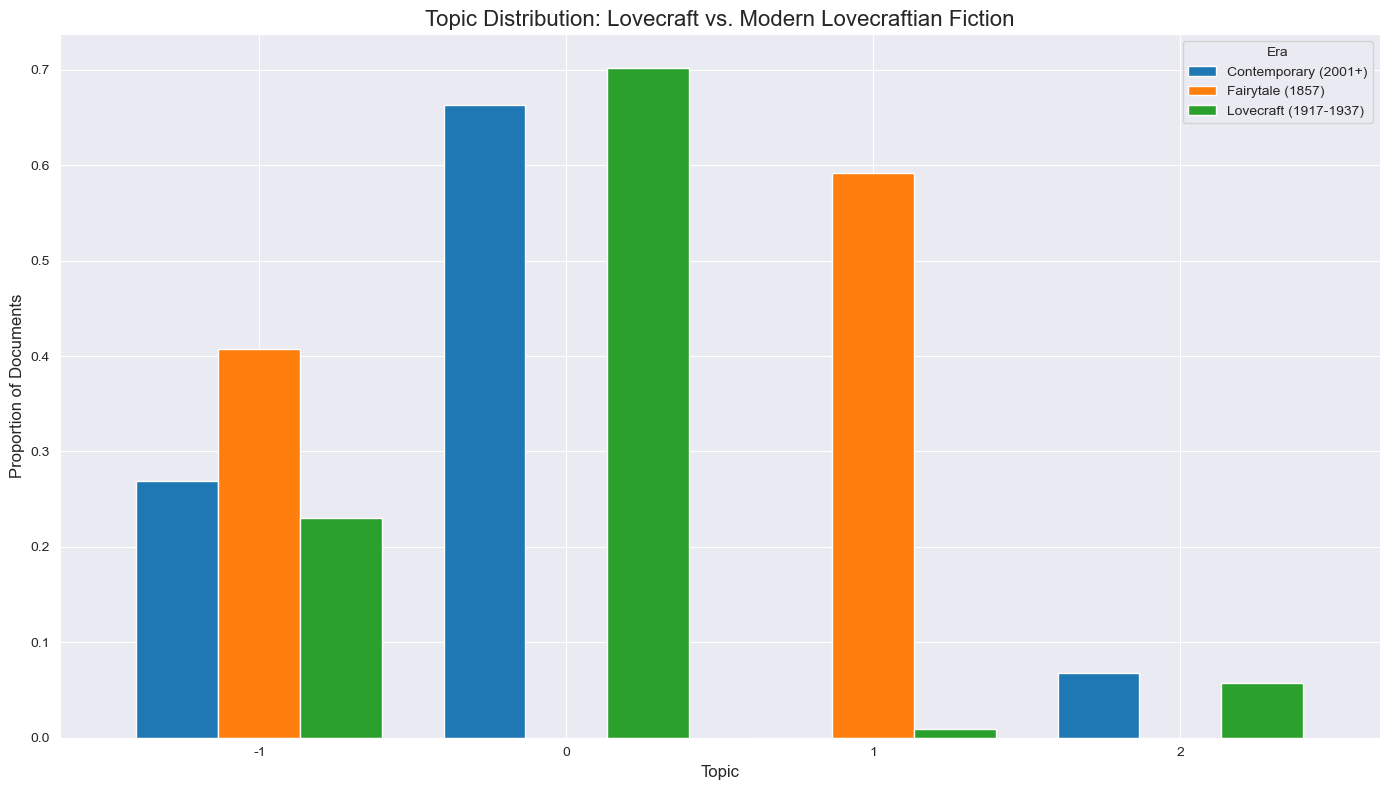


=== Topic Proportions ===
Era    Contemporary (2001+)  Fairytale (1857)  Lovecraft (1917-1937)
Topic                                                               
-1                 0.269231          0.407767               0.230769
 0                 0.663462          0.000000               0.701923
 1                 0.000000          0.592233               0.009615
 2                 0.067308          0.000000               0.057692


In [149]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [150]:
### Using custom stop words, umap ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/','./GrimmFairyTaleAgain/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=True))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
all_corpus_again_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        all_corpus_again_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
all_corpus_again_diversity_score = calculate_topic_diversity(all_corpus_again_top_words)
print(f"All Corpus with Grimm Again Diversity Score: {all_corpus_again_diversity_score}")

# Compute Uniqueness Score
all_corpus_again_uniqueness, all_corpus_again_per_topic_uniqueness = calculate_topic_uniqueness(all_corpus_again_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'all_corpus_again_tokens_stop_words_umap.pkl', 'all_corpus_again_topics_stop_words_umap.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.3372796864984524


=== Topic Information ===
   Topic  Count                                    Name  \
0      0    207                0_vast_ward_gods_despite   
1      1    104  1_tailor_king daughter_huntsman_gretel   

                                      Representation  \
0  [vast, ward, gods, despite, ahead, probably, m...   
1  [tailor, king daughter, huntsman, gretel, brot...   

                                             KeyBERT  \
0  [history, consciousness, horrors, grotesque, a...   
1  [huntsmen, huntsman, hansel, cinderella, broth...   

                                                 MMR  \
0  [vast, arkham, knowledge, sinister, tales, lib...   
1  [tailor, king daughter, gretel, brother lustig...   

                                 Representative_Docs  
0  [EDITOR’S NOTE: Alonzo Hasbrouck Typer of King...  
1  [There was once a man who understood all kinds...  

Topic 0:
[('vast', 0.01673063144622864), ('ward', 0.015069727502192827), ('gods', 0.014675774318627774), ('despite', 0.014

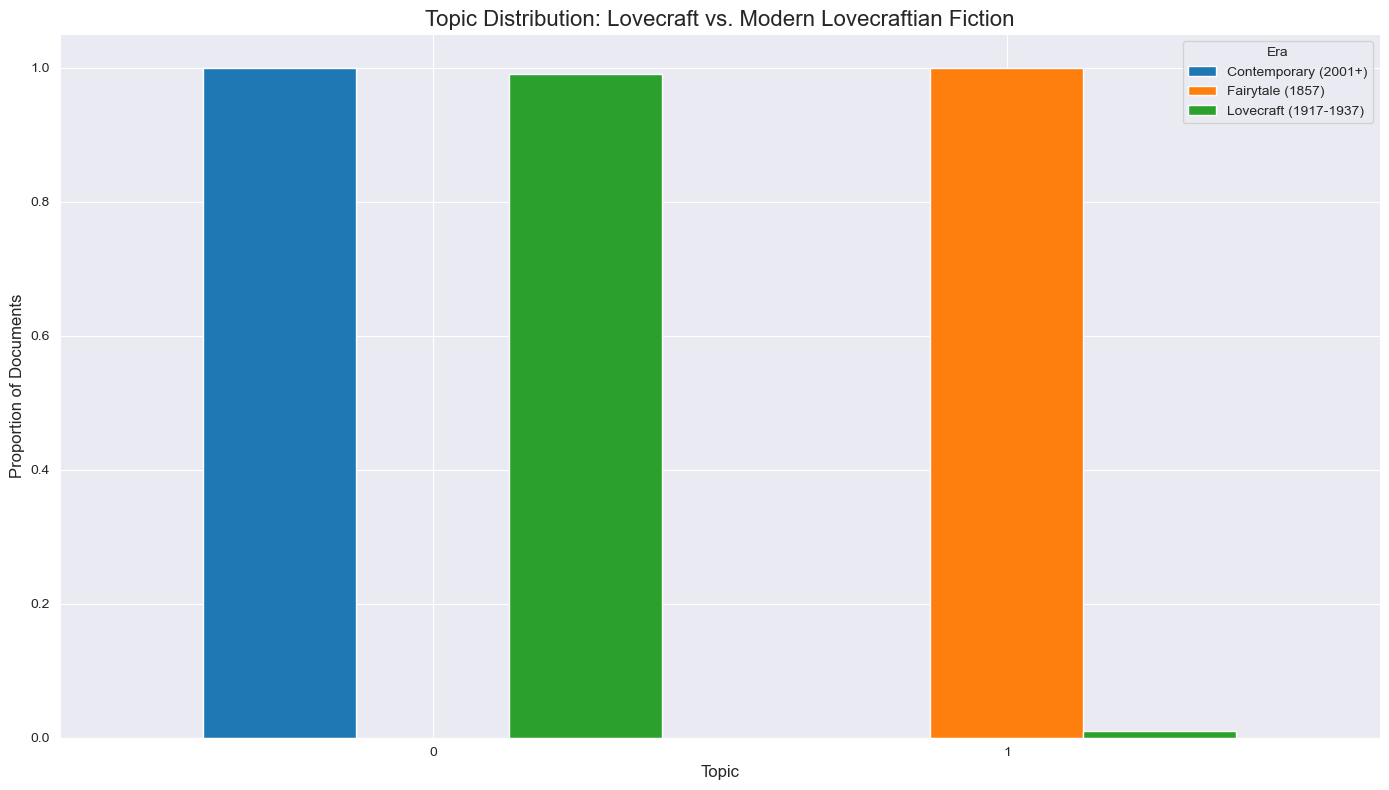


=== Topic Proportions ===
Era    Contemporary (2001+)  Fairytale (1857)  Lovecraft (1917-1937)
Topic                                                               
0                       1.0               0.0               0.990385
1                       0.0               1.0               0.009615


In [151]:
proportions = compare_era_topics(df)
print("\n=== Topic Proportions ===")
print(proportions)

In [152]:
### Using custom stop words only ###

df = convert_text_files(directories=['./Fan_text_files/', './fiction_text_files/','./GrimmFairyTaleAgain/'], label='fiction')

topic_model = init_BERTopic(*customize_BERTopic(stop_words=True, hdbscan=False, umap=False))

# Fit the model on text data
topics, probs = topic_model.fit_transform(df['Texts'])

# Reduce to specified number of topics
topic_model.reduce_topics(df['Texts'], nr_topics=bert_nr_topics)

# Retrieve updated topics after reduction
topics = topic_model.topics_

# Get updated probabilities after reduction
doc_info = topic_model.get_document_info(df['Texts'])

# Add topics back to dataframe
df['Topic'] = topics
df['Topic_Probability'] = doc_info['Probability'].values

# Get topic information
topic_info = topic_model.get_topic_info()
print("\n=== Topic Information ===")
print(topic_info)

# Display documents with their topics
#print("\n=== Documents with Assigned Topics ===")
# print(df[['Texts', 'Labels', 'Topic', 'Topic_Probability']])

# Get representative words for each topic
all_corpus_again_top_words = []
for topic_num in topic_info['Topic']:
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    if topic_num != -1:
        current_topic_top_words = topic_model.get_topic(topic_num)
        all_corpus_again_top_words.append(current_topic_top_words)

print()

# Get average probability for every topic
for topic_num in topic_info['Topic']:
    topic_mask = df['Topic'] == topic_num
    if topic_mask.any():
        avg_prob = df[topic_mask]['Topic_Probability'].mean()
        topic_label = "outlier" if topic_num == -1 else f"topic {topic_num}"
        print(f"Average {topic_label} probability: {avg_prob}")

print()

# Compute Diversity Score
all_corpus_again_diversity_score = calculate_topic_diversity(all_corpus_again_top_words)
print(f"All Corpus with Grimm Again Diversity Score: {all_corpus_again_diversity_score}")

# Compute Uniqueness Score
all_corpus_again_uniqueness, all_corpus_again_per_topic_uniqueness = calculate_topic_uniqueness(all_corpus_again_top_words)

# Retrieve topic list and words
token_list, topic_words = get_topic_list_and_topic_words(df, topic_model)
# Save token list and topic words to file
save_token_list_and_topics(token_list, topic_words,'all_corpus_again_tokens_stop_words.pkl', 'all_corpus_again_topics_stop_words.json')

# Print outlier file names for analysis
if len(df[df['Topic'] == -1]) > 0:
    outlier_indices = print_outlier_file_names(df, topic_model)

#Coherence (C_v:) 0.3372796864984524


=== Topic Information ===
   Topic  Count                                    Name  \
0      0    207                0_vast_ward_gods_despite   
1      1    104  1_tailor_king daughter_huntsman_gretel   

                                      Representation  \
0  [vast, ward, gods, despite, ahead, probably, m...   
1  [tailor, king daughter, huntsman, gretel, brot...   

                                             KeyBERT  \
0  [history, consciousness, horrors, grotesque, a...   
1  [huntsmen, huntsman, hansel, cinderella, broth...   

                                                 MMR  \
0  [vast, arkham, knowledge, sinister, tales, lib...   
1  [tailor, king daughter, gretel, brother lustig...   

                                 Representative_Docs  
0  [EDITOR’S NOTE: Alonzo Hasbrouck Typer of King...  
1  [There was once a man who understood all kinds...  

Topic 0:
[('vast', 0.01673063144622864), ('ward', 0.015069727502192827), ('gods', 0.014675774318627774), ('despite', 0.014